<a href="https://colab.research.google.com/github/DeepPandya30/Minor-Project/blob/main/MyDHC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

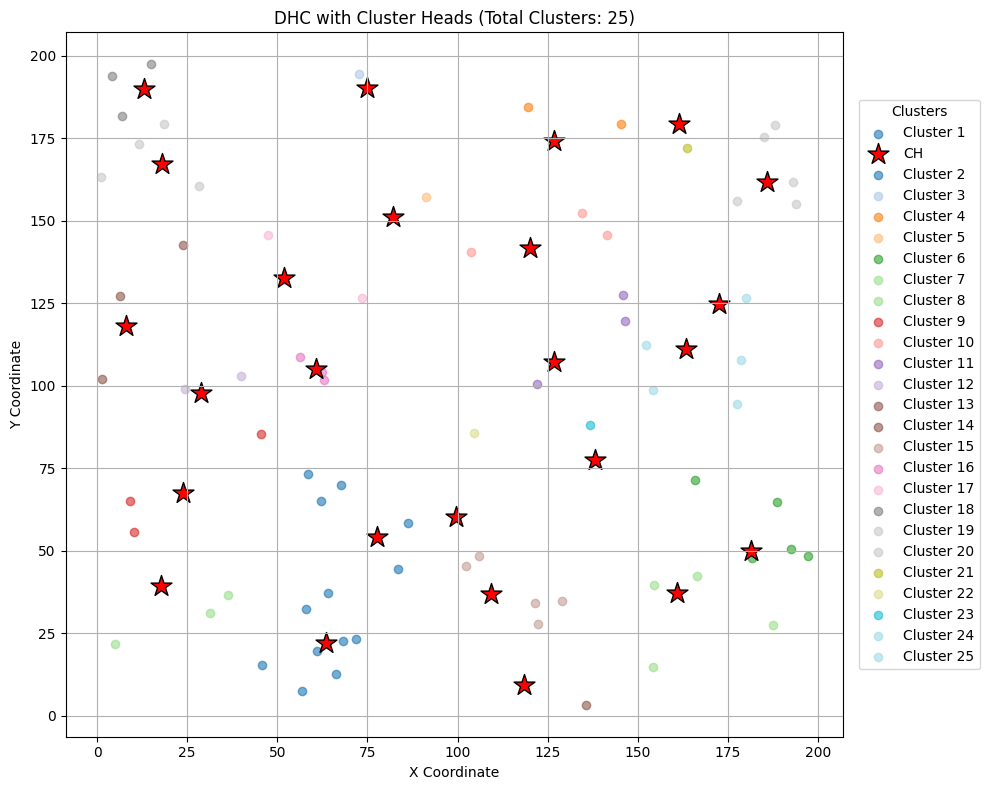

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# ---------------------------
# PARAMETERS
# ---------------------------
num_nodes = 100
area_size = 200
dth = 1500  # Threshold for max SSD in a cluster
np.random.seed(42)

# ---------------------------
# GENERATE NODES
# ---------------------------
nodes = np.random.rand(num_nodes, 2) * area_size

# ---------------------------
# DHC ALGORITHM
# ---------------------------
clusters = [{'points': nodes, 'label': 1}]
next_label = 2  # Start labeling from 2 because 1 is already used

def calculate_ssd(points, centroid):
    return np.sum(np.square(np.linalg.norm(points - centroid, axis=1)))

while True:
    max_ssd = -1
    max_cluster_index = -1
    for idx, cluster in enumerate(clusters):
        points = cluster['points']
        centroid = np.mean(points, axis=0)
        ssd = calculate_ssd(points, centroid)
        if ssd > max_ssd:
            max_ssd = ssd
            max_cluster_index = idx
    if max_ssd <= dth:
        break
    target_cluster = clusters.pop(max_cluster_index)
    points = target_cluster['points']
    kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(points)
    clusters.append({'points': points[labels == 0], 'label': next_label})
    next_label += 1
    clusters.append({'points': points[labels == 1], 'label': next_label})
    next_label += 1

# ---------------------------
# SELECT CLUSTER HEADS
# ---------------------------
cluster_heads = []
for cluster in clusters:
    pts = cluster['points']
    centroid = np.mean(pts, axis=0)
    distances = np.linalg.norm(pts - centroid, axis=1)
    ch_index = np.argmin(distances)
    ch_point = pts[ch_index]
    cluster['centroid'] = centroid
    cluster['ch'] = ch_point
    cluster_heads.append(ch_point)

cluster_heads = np.array(cluster_heads)

# ---------------------------
# PLOT FINAL CLUSTERS WITH CLUSTER HEADS
# ---------------------------
plt.figure(figsize=(10, 8))
colors = plt.cm.tab20(np.linspace(0, 1, len(clusters)))

for i, cluster in enumerate(clusters):
    pts = cluster['points']
    ch = cluster['ch']
    label_number = i + 1  # Now labels start from 1
    plt.scatter(pts[:, 0], pts[:, 1], label=f'Cluster {label_number}', color=colors[i], alpha=0.6)
    plt.scatter(ch[0], ch[1], color='red', marker='*', s=250, edgecolor='black', label='CH' if i == 0 else "")

plt.title(f'DHC with Cluster Heads (Total Clusters: {len(clusters)})')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)

# Move legend outside plot
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0, title="Clusters")
plt.tight_layout()
plt.show()


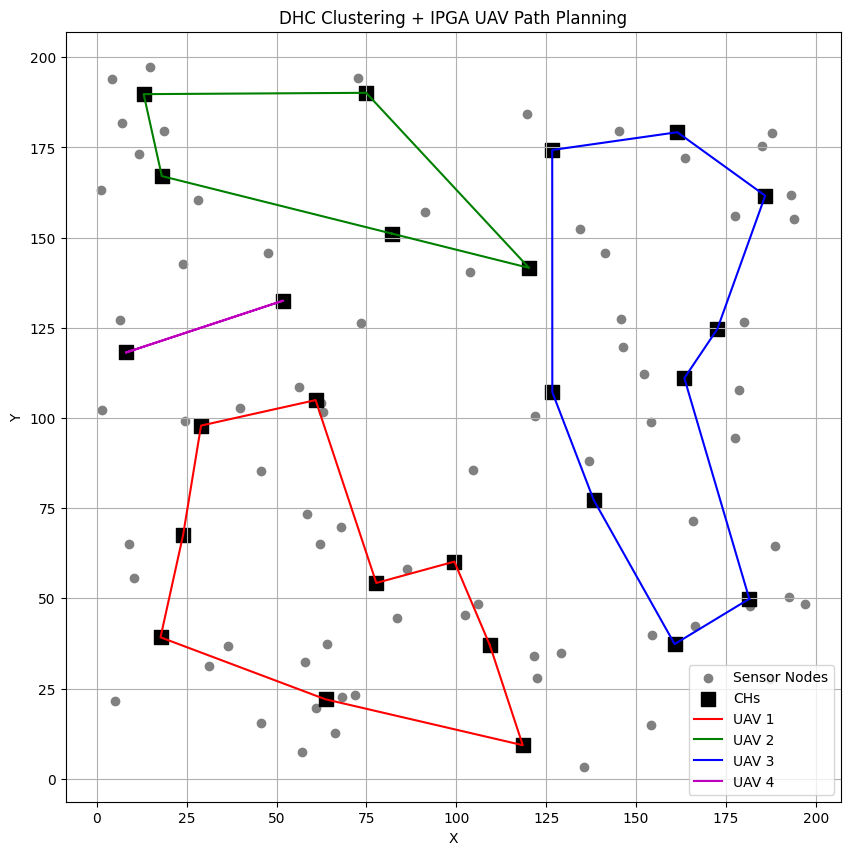

In [ ]:
---import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans

# ---------------------------
# PARAMETERS
# ---------------------------
NUM_NODES = 100  # Number of raw sensor nodes
DTH = 1500  # DHC threshold for maximum sum of squared distances in a cluster
NUM_UAV = 4  # Number of UAVs (salesmen)
POP_SIZE = 50  # IPGA population size
MAX_GEN = 100  # Number of generations
ALPHA = 0.8  # Weighting factor for objective function
np.random.seed(42)

# ---------------------------
# GENERATE RANDOM NODES
# ---------------------------
nodes = np.random.rand(NUM_NODES, 2) * 200

# ---------------------------
# DHC CLUSTERING USING KMEANS++
# ---------------------------
def dhc_clustering(nodes, dth):
    clusters = [list(range(len(nodes)))]
    centroids = []

    while True:
        max_sse = 0
        max_cluster_idx = -1
        cluster_centroids = []
        cluster_sse = []

        for idx, cluster in enumerate(clusters):
            cluster_points = nodes[cluster]
            kmeans = KMeans(n_clusters=1, init='k-means++', n_init=1).fit(cluster_points)
            centroid = kmeans.cluster_centers_[0]
            sse = np.sum((cluster_points - centroid) ** 2)
            cluster_sse.append(sse)
            cluster_centroids.append(centroid)
            if sse > max_sse:
                max_sse = sse
                max_cluster_idx = idx

        if max_sse <= dth:
            break

        target_cluster = clusters.pop(max_cluster_idx)
        kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10).fit(nodes[target_cluster])
        labels = kmeans.labels_
        new_clusters = [[], []]
        for i, label in zip(target_cluster, labels):
            new_clusters[label].append(i)
        clusters.extend(new_clusters)

    return clusters

# ---------------------------
# CLUSTER HEAD SELECTION
# ---------------------------
def select_cluster_heads(clusters, nodes):
    chs = []
    for cluster in clusters:
        cluster_points = nodes[cluster]
        centroid = np.mean(cluster_points, axis=0)
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        ch_index = cluster[np.argmin(distances)]
        chs.append(ch_index)
    return chs

# ---------------------------
# DISTANCE MATRIX
# ---------------------------
def calculate_distance_matrix(coords):
    n = len(coords)
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist[i, j] = np.linalg.norm(coords[i] - coords[j])
    return dist

# ---------------------------
# OBJECTIVE FUNCTION
# ---------------------------
def evaluate(individual, dist_matrix):
    paths = decode_individual(individual, NUM_UAV)
    total_dist = 0
    max_dist = 0
    for path in paths:
        if len(path) == 0:
            continue
        d = sum(dist_matrix[path[i], path[i+1]] for i in range(len(path)-1))
        d += dist_matrix[path[-1], path[0]]  # Return to start
        total_dist += d
        max_dist = max(max_dist, d)
    return ALPHA * total_dist + (1 - ALPHA) * NUM_UAV * max_dist

# ---------------------------
# ENCODING / DECODING
# ---------------------------
def encode_individual(n):
    nodes = list(range(n))
    random.shuffle(nodes)
    breakpoints = sorted(random.sample(range(1, n), NUM_UAV - 1))
    return nodes + breakpoints

def decode_individual(ind, k):
    n = len(ind) - (k - 1)
    nodes = ind[:n]
    breaks = ind[n:]
    breaks = [0] + breaks + [n]
    paths = []
    for i in range(k):
        paths.append(nodes[breaks[i]:breaks[i+1]])
    return paths

# ---------------------------
# HIM GROUP EVOLUTION
# ---------------------------
def mutate(ind):
    n = len(ind) - (NUM_UAV - 1)
    new_ind = ind[:]
    op = random.choice(['swap', 'slide', 'flip'])
    i, j = sorted(random.sample(range(n), 2))
    if op == 'swap':
        new_ind[i], new_ind[j] = new_ind[j], new_ind[i]
    elif op == 'slide':
        new_ind = new_ind[:i] + [new_ind[j]] + new_ind[i:j] + new_ind[j+1:]
    elif op == 'flip':
        new_ind[i:j+1] = list(reversed(new_ind[i:j+1]))
    return new_ind

# ---------------------------
# DHC + CLUSTER HEADS + IPGA
# ---------------------------
clusters = dhc_clustering(nodes, DTH)
ch_indices = select_cluster_heads(clusters, nodes)
cluster_heads = nodes[ch_indices]
dist_matrix = calculate_distance_matrix(cluster_heads)

# INITIALIZE IPGA POPULATION
population = [encode_individual(len(cluster_heads)) for _ in range(POP_SIZE)]
best_ind = None
best_fit = float('inf')

for gen in range(MAX_GEN):
    fitness = [evaluate(ind, dist_matrix) for ind in population]
    for i in range(0, POP_SIZE, 8):
        group = population[i:i+8]
        group_fit = fitness[i:i+8]
        best_idx = np.argmin(group_fit)
        p_best = group[best_idx]
        children = [p_best]
        for _ in range(7):
            child = mutate(p_best)
            children.append(child)
        child_fitness = [evaluate(ind, dist_matrix) for ind in children]
        if min(child_fitness) < best_fit:
            best_fit = min(child_fitness)
            best_ind = children[np.argmin(child_fitness)]
        population[i:i+8] = children

# ---------------------------
# PLOT FINAL UAV PATHS
# ---------------------------
paths = decode_individual(best_ind, NUM_UAV)
colors = ['r', 'g', 'b', 'm', 'c']

plt.figure(figsize=(10, 10))
plt.scatter(nodes[:, 0], nodes[:, 1], c='gray', label='Sensor Nodes')
plt.scatter(cluster_heads[:, 0], cluster_heads[:, 1], c='black', marker='s', s=100, label='CHs')

for i, path in enumerate(paths):
    path_coords = cluster_heads[path]
    path_coords = np.vstack([path_coords, path_coords[0]])
    plt.plot(path_coords[:, 0], path_coords[:, 1], color=colors[i % len(colors)], label=f'UAV {i+1}')

plt.title('DHC Clustering + IPGA UAV Path Planning')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


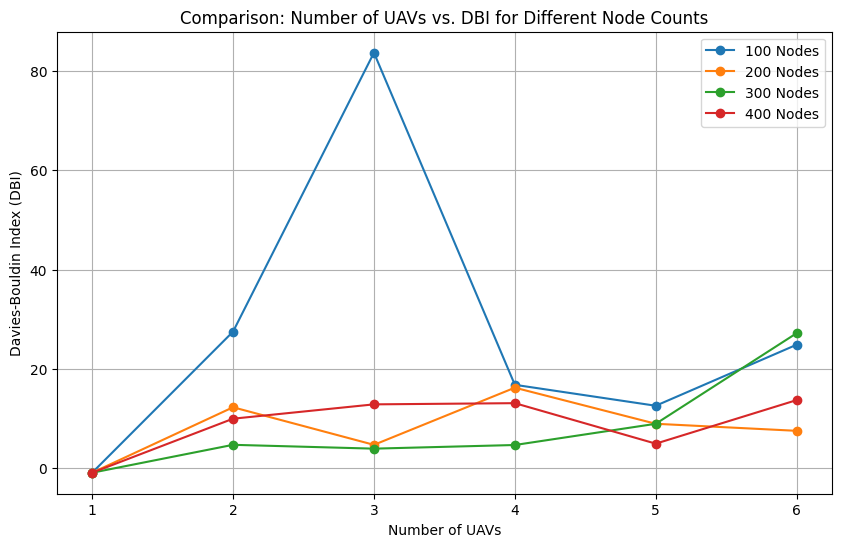

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans

# ---------------------------
# PARAMETERS
# ---------------------------
POP_SIZE = 50  # IPGA population size
MAX_GEN = 100  # Number of generations
ALPHA = 0.8  # Weighting factor for objective function
np.random.seed(42)

# ---------------------------
# DBI FUNCTION
# ---------------------------
def calculate_dbi(clusters, nodes):
    k = len(clusters)
    centroids = [np.mean(nodes[cluster], axis=0) for cluster in clusters]
    sigma = []
    for i, cluster in enumerate(clusters):
        intra_dist = [np.linalg.norm(nodes[p] - centroids[i]) for p in cluster]
        sigma.append(np.mean(intra_dist))

    dbi_sum = 0
    for i in range(k):
        max_ratio = -1
        for j in range(k):
            if i != j:
                inter_dist = np.linalg.norm(centroids[i] - centroids[j])
                ratio = (sigma[i] + sigma[j]) / inter_dist
                max_ratio = max(max_ratio, ratio)
        dbi_sum += max_ratio
    return dbi_sum / k

# ---------------------------
# DHC CLUSTERING FUNCTION
# ---------------------------
def dhc_clustering(nodes, dth):
    clusters = [list(range(len(nodes)))]
    while True:
        max_sse = 0
        max_cluster_idx = -1
        for idx, cluster in enumerate(clusters):
            cluster_points = nodes[cluster]
            kmeans = KMeans(n_clusters=1, init='k-means++', n_init=1).fit(cluster_points)
            centroid = kmeans.cluster_centers_[0]
            sse = np.sum((cluster_points - centroid) ** 2)
            if sse > max_sse:
                max_sse = sse
                max_cluster_idx = idx

        if max_sse <= dth:
            break

        target_cluster = clusters.pop(max_cluster_idx)
        kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10).fit(nodes[target_cluster])
        labels = kmeans.labels_
        new_clusters = [[], []]
        for i, label in zip(target_cluster, labels):
            new_clusters[label].append(i)
        clusters.extend(new_clusters)

    return clusters

# ---------------------------
# MAIN ANALYSIS FOR COMPARISON
# ---------------------------
nodes_range = [100, 200, 300, 400]
uavs_required = list(range(1, 7))

results = {}

for NUM_NODES in nodes_range:
    DTH = 20 * NUM_NODES
    nodes = np.random.rand(NUM_NODES, 2) * 200
    node_dbi = []

    for NUM_UAV in uavs_required:
        clusters = dhc_clustering(nodes, DTH)

        # Assign clusters to UAVs (simple partitioning)
        cluster_groups = [[] for _ in range(NUM_UAV)]
        for idx, cluster in enumerate(clusters):
            cluster_groups[idx % NUM_UAV].extend(cluster)

        grouped_clusters = []
        for group in cluster_groups:
            if group:
                grouped_clusters.append(group)

        dbi = calculate_dbi(grouped_clusters, nodes)
        node_dbi.append(dbi)

    results[NUM_NODES] = node_dbi

# ---------------------------
# PLOT COMPARISON GRAPH
# ---------------------------
plt.figure(figsize=(10, 6))
for NUM_NODES in nodes_range:
    plt.plot(uavs_required, results[NUM_NODES], marker='o', label=f'{NUM_NODES} Nodes')

plt.title('Comparison: Number of UAVs vs. DBI for Different Node Counts')
plt.xlabel('Number of UAVs')
plt.ylabel('Davies-Bouldin Index (DBI)')
plt.legend()
plt.grid(True)
plt.show()


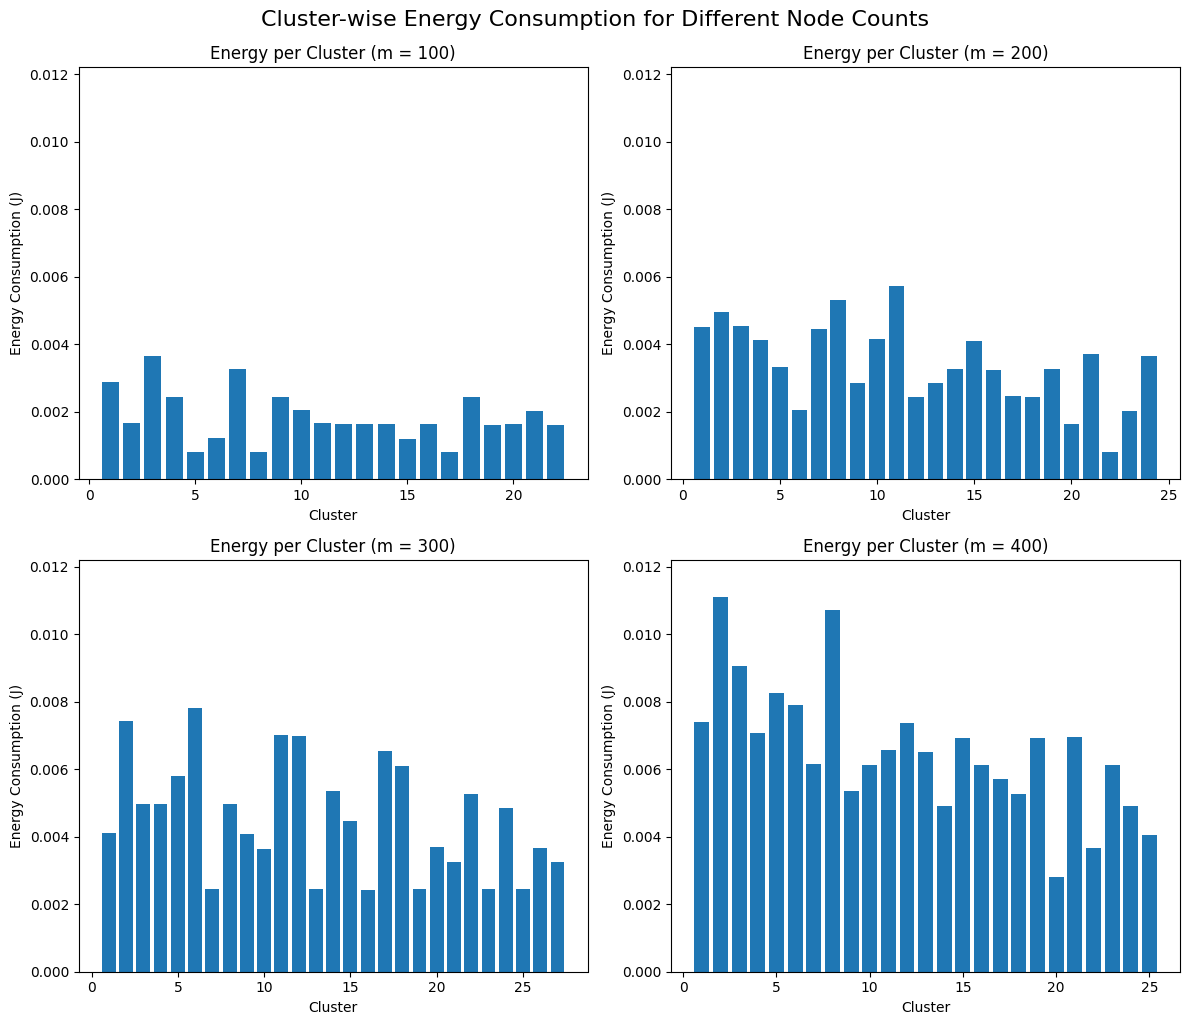

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans

# ---------------------------
# PARAMETERS
# ---------------------------
POP_SIZE = 50  # IPGA population size
MAX_GEN = 100  # Number of generations
ALPHA = 0.8  # Weighting factor for objective function
np.random.seed(42)

# ---------------------------
# DBI FUNCTION
# ---------------------------
def calculate_dbi(clusters, nodes):
    k = len(clusters)
    centroids = [np.mean(nodes[cluster], axis=0) for cluster in clusters]
    sigma = []
    for i, cluster in enumerate(clusters):
        intra_dist = [np.linalg.norm(nodes[p] - centroids[i]) for p in cluster]
        sigma.append(np.mean(intra_dist))

    dbi_sum = 0
    for i in range(k):
        max_ratio = -1
        for j in range(k):
            if i != j:
                inter_dist = np.linalg.norm(centroids[i] - centroids[j])
                ratio = (sigma[i] + sigma[j]) / inter_dist
                max_ratio = max(max_ratio, ratio)
        dbi_sum += max_ratio
    return dbi_sum / k

# ---------------------------
# ENERGY CONSUMPTION FUNCTION
# ---------------------------
def calculate_energy(nodes, clusters, d0=50, Eelec=50e-9, Efs=10e-12, Emp=0.0013e-12, l=4000):
    energy = []
    for cluster in clusters:
        cluster_nodes = nodes[cluster]
        centroid = np.mean(cluster_nodes, axis=0)
        total_energy = 0
        for node in cluster_nodes:
            d = np.linalg.norm(node - centroid)
            if d < d0:
                Es = l * Eelec + l * Efs * d ** 2
            else:
                Es = l * Eelec + l * Emp * d ** 4
            Er = l * Eelec
            total_energy += Es + Er
        energy.append(total_energy)
    return energy

# ---------------------------
# DHC CLUSTERING FUNCTION
# ---------------------------
def dhc_clustering(nodes, dth):
    clusters = [list(range(len(nodes)))]
    while True:
        max_sse = 0
        max_cluster_idx = -1
        for idx, cluster in enumerate(clusters):
            cluster_points = nodes[cluster]
            kmeans = KMeans(n_clusters=1, init='k-means++', n_init=1).fit(cluster_points)
            centroid = kmeans.cluster_centers_[0]
            sse = np.sum((cluster_points - centroid) ** 2)
            if sse > max_sse:
                max_sse = sse
                max_cluster_idx = idx

        if max_sse <= dth:
            break

        target_cluster = clusters.pop(max_cluster_idx)
        kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10).fit(nodes[target_cluster])
        labels = kmeans.labels_
        new_clusters = [[], []]
        for i, label in zip(target_cluster, labels):
            new_clusters[label].append(i)
        clusters.extend(new_clusters)

    return clusters

# ---------------------------
# MAIN ANALYSIS FOR COMPARISON
# ---------------------------
nodes_range = [100, 200, 300, 400]
uavs_required = list(range(1, 7))

results = {}
energy_results = {}
cluster_energy_details = {}

for NUM_NODES in nodes_range:
    DTH = 20 * NUM_NODES
    nodes = np.random.rand(NUM_NODES, 2) * 200
    node_dbi = []
    node_energy = []

    clusters = dhc_clustering(nodes, DTH)
    grouped_clusters = [cluster for cluster in clusters if cluster]
    cluster_energy = calculate_energy(nodes, grouped_clusters)
    cluster_energy_details[NUM_NODES] = cluster_energy

    for NUM_UAV in uavs_required:
        cluster_groups = [[] for _ in range(NUM_UAV)]
        for idx, cluster in enumerate(clusters):
            cluster_groups[idx % NUM_UAV].extend(cluster)

        grouped_clusters = [group for group in cluster_groups if group]

        dbi = calculate_dbi(grouped_clusters, nodes)
        energy = calculate_energy(nodes, grouped_clusters)

        node_dbi.append(dbi)
        node_energy.append(np.sum(energy))

    results[NUM_NODES] = node_dbi
    energy_results[NUM_NODES] = node_energy


# ---------------------------
# PLOT ENERGY CONSUMPTION PER CLUSTER
# ---------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for idx, NUM_NODES in enumerate(nodes_range):
    energy_values = cluster_energy_details[NUM_NODES]
    cluster_indices = list(range(1, len(energy_values)+1))
    axs[idx].bar(cluster_indices, energy_values)
    axs[idx].set_title(f'Energy per Cluster (m = {NUM_NODES})')
    axs[idx].set_xlabel('Cluster')
    axs[idx].set_ylabel('Energy Consumption (J)')
    axs[idx].set_ylim([0, max([max(v) for v in cluster_energy_details.values()]) * 1.1])

plt.tight_layout()
plt.suptitle('Cluster-wise Energy Consumption for Different Node Counts', fontsize=16, y=1.02)
plt.show()

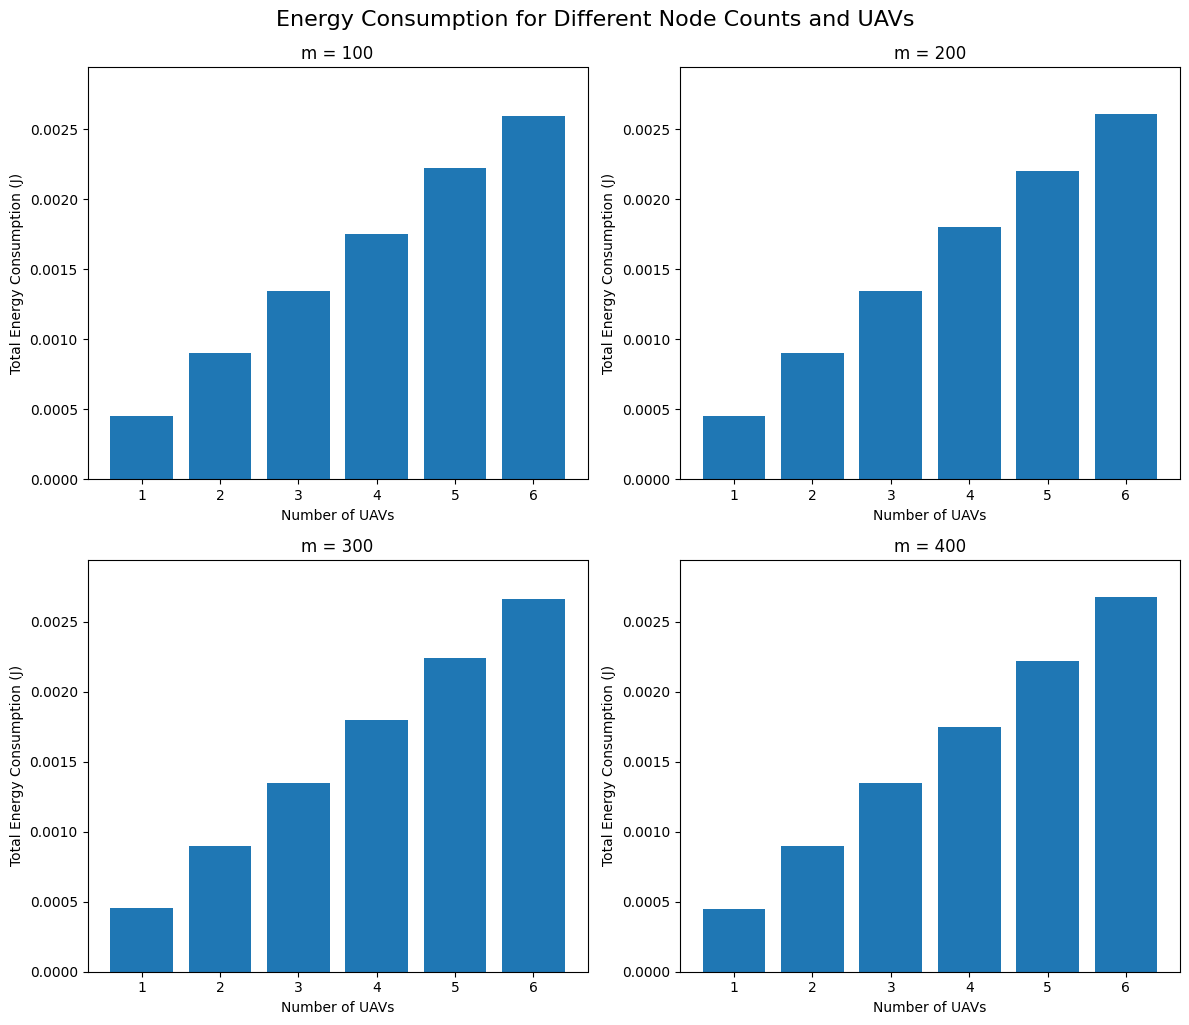

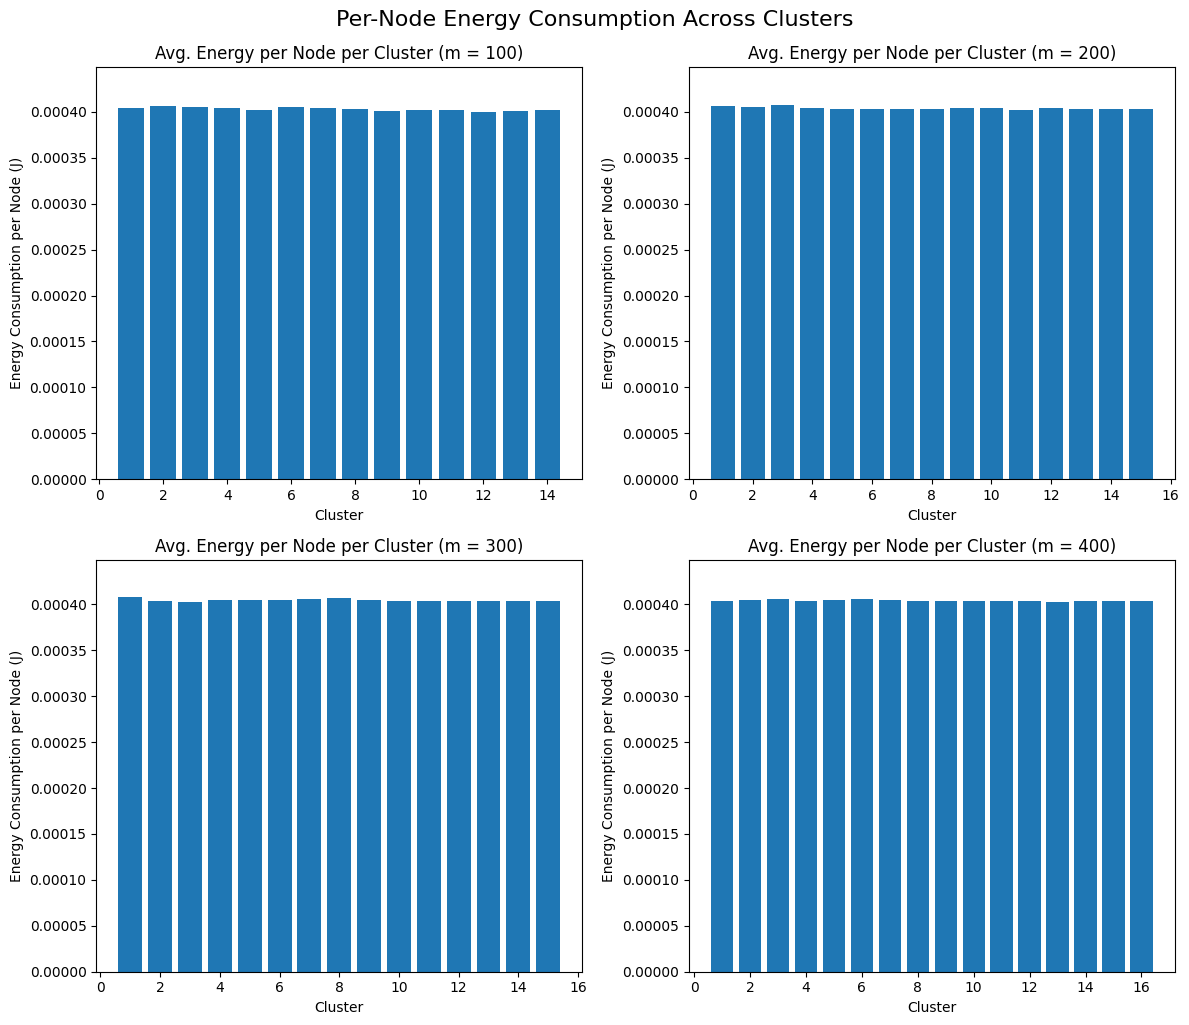

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans

# ---------------------------
# PARAMETERS
# ---------------------------
POP_SIZE = 50  # IPGA population size
MAX_GEN = 100  # Number of generations
ALPHA = 0.5  # Weighting factor for objective function
np.random.seed(42)

# ---------------------------
# DBI FUNCTION
# ---------------------------
def calculate_dbi(clusters, nodes):
    k = len(clusters)
    centroids = [np.mean(nodes[cluster], axis=0) for cluster in clusters]
    sigma = []
    for i, cluster in enumerate(clusters):
        intra_dist = [np.linalg.norm(nodes[p] - centroids[i]) for p in cluster]
        sigma.append(np.mean(intra_dist))

    dbi_sum = 0
    for i in range(k):
        max_ratio = -1
        for j in range(k):
            if i != j:
                inter_dist = np.linalg.norm(centroids[i] - centroids[j])
                ratio = (sigma[i] + sigma[j]) / inter_dist
                max_ratio = max(max_ratio, ratio)
        dbi_sum += max_ratio
    return dbi_sum / k

# ---------------------------
# ENERGY CONSUMPTION FUNCTION
# ---------------------------
def calculate_energy(nodes, clusters, d0=50, Eelec=50e-9, Efs=10e-12, Emp=0.0013e-12, l=4000):
    energy = []
    for cluster in clusters:
        cluster_nodes = nodes[cluster]
        centroid = np.mean(cluster_nodes, axis=0)
        total_energy = 0
        for node in cluster_nodes:
            d = np.linalg.norm(node - centroid)
            if d < d0:
                Es = l * Eelec + l * Efs * d ** 2
            else:
                Es = l * Eelec + l * Emp * d ** 4
            Er = l * Eelec
            total_energy += Es + Er
        energy.append(total_energy / len(cluster))  # Normalize per node
    return energy

# ---------------------------
# DHC CLUSTERING FUNCTION
# ---------------------------
def dhc_clustering(nodes, dth):
    clusters = [list(range(len(nodes)))]
    while True:
        max_sse = 0
        max_cluster_idx = -1
        for idx, cluster in enumerate(clusters):
            cluster_points = nodes[cluster]
            kmeans = KMeans(n_clusters=1, init='k-means++', n_init=1).fit(cluster_points)
            centroid = kmeans.cluster_centers_[0]
            sse = np.sum((cluster_points - centroid) ** 2)
            if sse > max_sse:
                max_sse = sse
                max_cluster_idx = idx

        if max_sse <= dth:
            break

        target_cluster = clusters.pop(max_cluster_idx)
        kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10).fit(nodes[target_cluster])
        labels = kmeans.labels_
        new_clusters = [[], []]
        for i, label in zip(target_cluster, labels):
            new_clusters[label].append(i)
        clusters.extend(new_clusters)

    return clusters

# ---------------------------
# MAIN ANALYSIS FOR COMPARISON
# ---------------------------
nodes_range = [100, 200, 300, 400]
uavs_required = list(range(1, 7))

results = {}
energy_results = {}
cluster_energy_details = {}

for NUM_NODES in nodes_range:
    DTH = 20 * NUM_NODES
    nodes = np.random.rand(NUM_NODES, 2) * 100
    node_dbi = []
    node_energy = []

    clusters = dhc_clustering(nodes, DTH)
    grouped_clusters = [cluster for cluster in clusters if cluster]
    cluster_energy = calculate_energy(nodes, grouped_clusters)
    cluster_energy_details[NUM_NODES] = cluster_energy

    for NUM_UAV in uavs_required:
        cluster_groups = [[] for _ in range(NUM_UAV)]
        for idx, cluster in enumerate(clusters):
            cluster_groups[idx % NUM_UAV].extend(cluster)

        grouped_clusters = [group for group in cluster_groups if group]

        dbi = calculate_dbi(grouped_clusters, nodes)
        energy = calculate_energy(nodes, grouped_clusters)

        node_dbi.append(dbi)
        node_energy.append(np.sum(energy))

    results[NUM_NODES] = node_dbi
    energy_results[NUM_NODES] = node_energy


# ---------------------------
# PLOT ENERGY BAR GRAPH PER UAV
# ---------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for idx, NUM_NODES in enumerate(nodes_range):
    axs[idx].bar(uavs_required, energy_results[NUM_NODES])
    axs[idx].set_title(f'm = {NUM_NODES}')
    axs[idx].set_xlabel('Number of UAVs')
    axs[idx].set_ylabel('Total Energy Consumption (J)')
    axs[idx].set_ylim([0, max([max(v) for v in energy_results.values()]) * 1.1])

plt.tight_layout()
plt.suptitle('Energy Consumption for Different Node Counts and UAVs', fontsize=16, y=1.02)
plt.show()

# ---------------------------
# PLOT NORMALIZED ENERGY PER NODE PER CLUSTER
# ---------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for idx, NUM_NODES in enumerate(nodes_range):
    energy_values = cluster_energy_details[NUM_NODES]
    cluster_indices = list(range(1, len(energy_values)+1))
    axs[idx].bar(cluster_indices, energy_values)
    axs[idx].set_title(f'Avg. Energy per Node per Cluster (m = {NUM_NODES})')
    axs[idx].set_xlabel('Cluster')
    axs[idx].set_ylabel('Energy Consumption per Node (J)')
    axs[idx].set_ylim([0, max([max(v) for v in cluster_energy_details.values()]) * 1.1])

plt.tight_layout()
plt.suptitle('Per-Node Energy Consumption Across Clusters', fontsize=16, y=1.02)
plt.show()

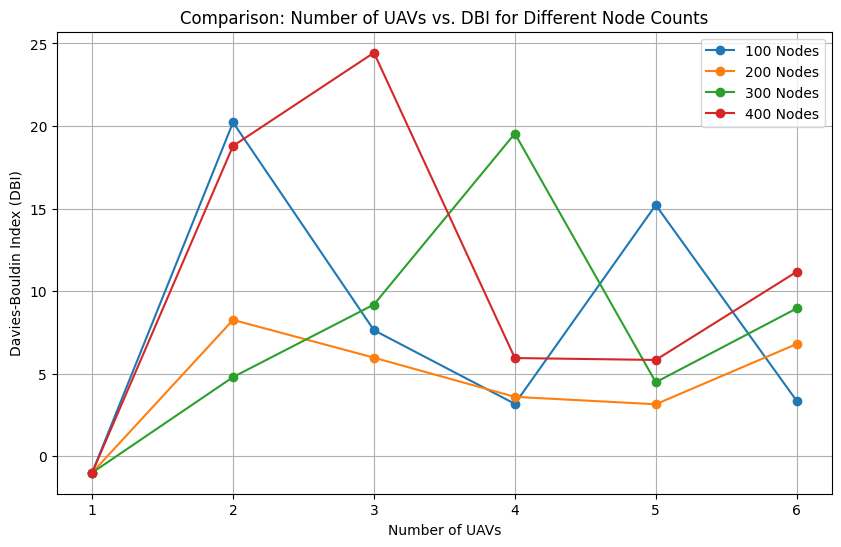

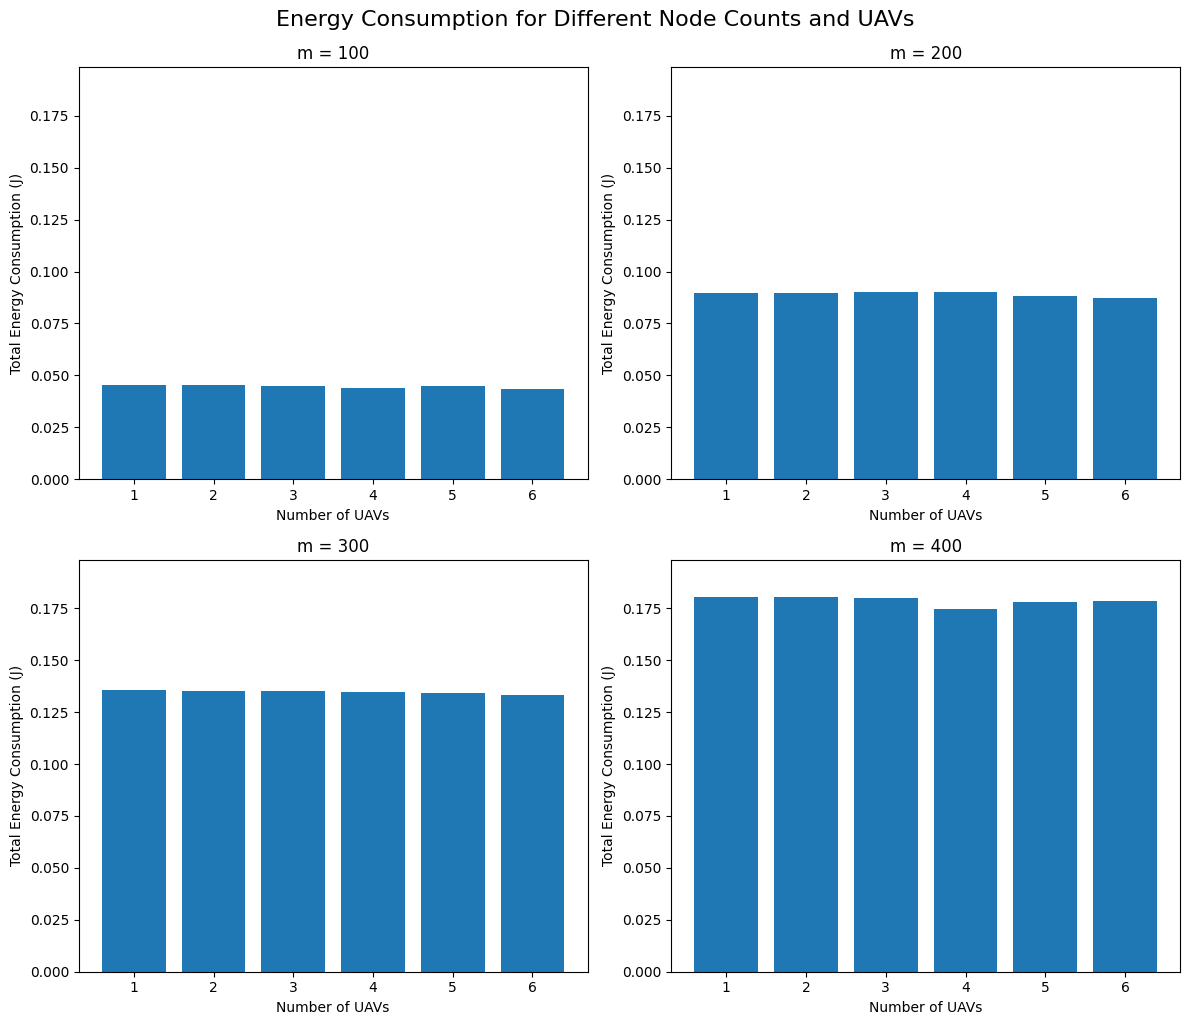

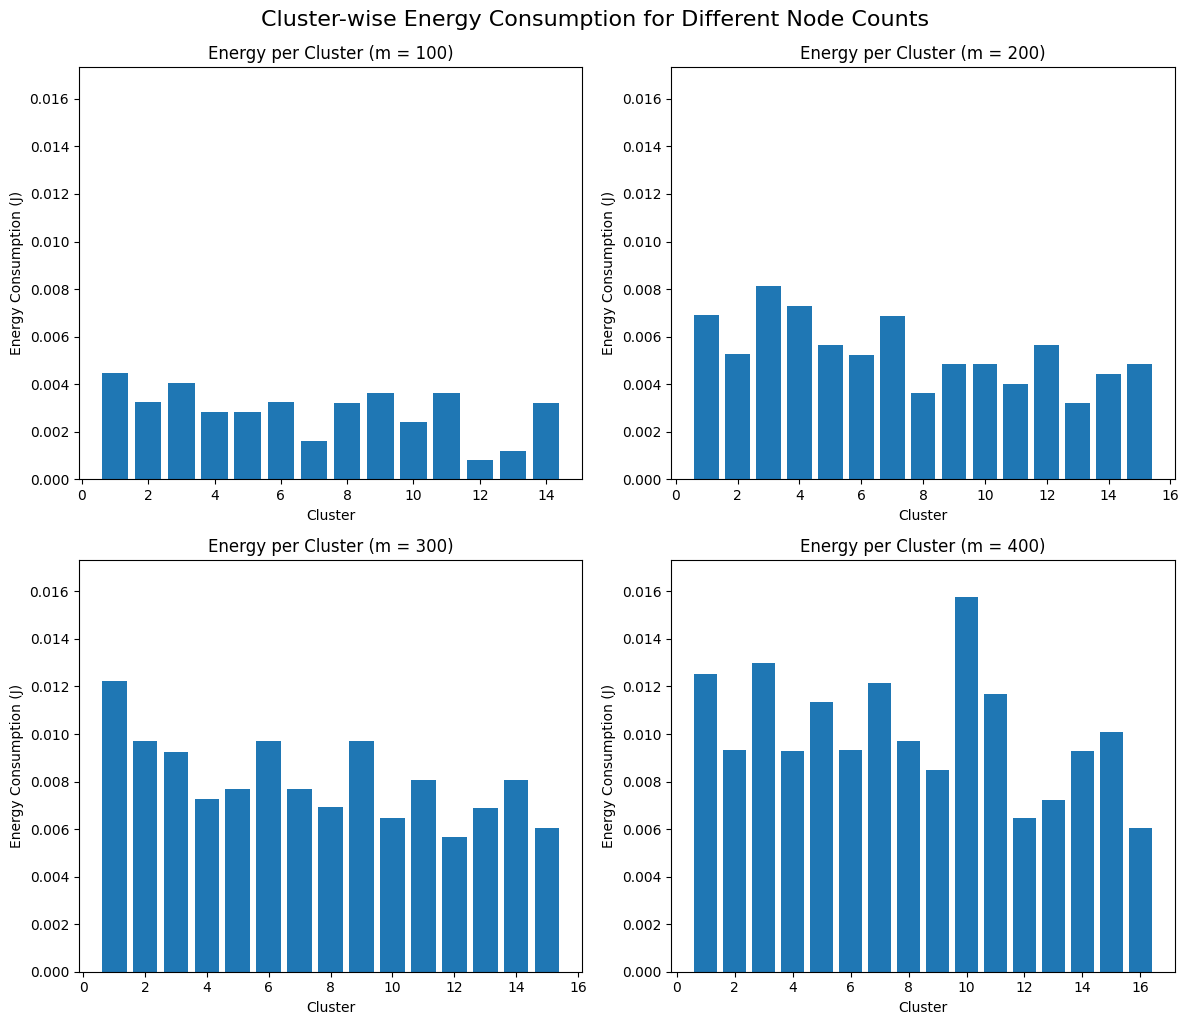

Total Path Distance Covered for Each Node Count:
100 nodes: 843.51 units
200 nodes: 1823.23 units
300 nodes: 2938.28 units
400 nodes: 3733.38 units


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

# ---------------------------
# PARAMETERS
# ---------------------------
POP_SIZE = 50  # IPGA population size
MAX_GEN = 100  # Number of generations
ALPHA = 0.5  # Weighting factor for objective function
np.random.seed(42)

# ---------------------------
# DBI FUNCTION
# ---------------------------
def calculate_dbi(clusters, nodes):
    k = len(clusters)
    centroids = [np.mean(nodes[cluster], axis=0) for cluster in clusters]
    sigma = []
    for i, cluster in enumerate(clusters):
        intra_dist = [np.linalg.norm(nodes[p] - centroids[i]) for p in cluster]
        sigma.append(np.mean(intra_dist))

    dbi_sum = 0
    for i in range(k):
        max_ratio = -1
        for j in range(k):
            if i != j:
                inter_dist = np.linalg.norm(centroids[i] - centroids[j])
                ratio = (sigma[i] + sigma[j]) / inter_dist
                max_ratio = max(max_ratio, ratio)
        dbi_sum += max_ratio
    return dbi_sum / k

# ---------------------------
# ENERGY CONSUMPTION FUNCTION
# ---------------------------
def calculate_energy(nodes, clusters, d0=50, Eelec=50e-9, Efs=10e-12, Emp=0.0013e-12, l=4000):
    energy = []
    for cluster in clusters:
        cluster_nodes = nodes[cluster]
        centroid = np.mean(cluster_nodes, axis=0)
        total_energy = 0
        for node in cluster_nodes:
            d = np.linalg.norm(node - centroid)
            if d < d0:
                Es = l * Eelec + l * Efs * d ** 2
            else:
                Es = l * Eelec + l * Emp * d ** 4
            Er = l * Eelec
            total_energy += Es + Er
        energy.append(total_energy)
    return energy

# ---------------------------
# TOTAL PATH DISTANCE FUNCTION
# ---------------------------
def calculate_total_path_distance(nodes, clusters):
    total_distance = 0
    for cluster in clusters:
        cluster_nodes = nodes[cluster]
        centroid = np.mean(cluster_nodes, axis=0)
        for node in cluster_nodes:
            total_distance += euclidean(node, centroid)
    return total_distance

# ---------------------------
# DHC CLUSTERING FUNCTION
# ---------------------------
def dhc_clustering(nodes, dth):
    clusters = [list(range(len(nodes)))]
    while True:
        max_sse = 0
        max_cluster_idx = -1
        for idx, cluster in enumerate(clusters):
            cluster_points = nodes[cluster]
            kmeans = KMeans(n_clusters=1, init='k-means++', n_init=1).fit(cluster_points)
            centroid = kmeans.cluster_centers_[0]
            sse = np.sum((cluster_points - centroid) ** 2)
            if sse > max_sse:
                max_sse = sse
                max_cluster_idx = idx

        if max_sse <= dth:
            break

        target_cluster = clusters.pop(max_cluster_idx)
        kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10).fit(nodes[target_cluster])
        labels = kmeans.labels_
        new_clusters = [[], []]
        for i, label in zip(target_cluster, labels):
            new_clusters[label].append(i)
        clusters.extend(new_clusters)

    return clusters

# ---------------------------
# MAIN ANALYSIS FOR COMPARISON
# ---------------------------
nodes_range = [100, 200, 300, 400]
uavs_required = list(range(1, 7))

results = {}
energy_results = {}
cluster_energy_details = {}
path_distances = {}

for NUM_NODES in nodes_range:
    DTH = 20 * NUM_NODES
    nodes = np.random.rand(NUM_NODES, 2) * 100
    node_dbi = []
    node_energy = []

    clusters = dhc_clustering(nodes, DTH)
    grouped_clusters = [cluster for cluster in clusters if cluster]
    cluster_energy = calculate_energy(nodes, grouped_clusters)
    cluster_energy_details[NUM_NODES] = cluster_energy

    path_distance = calculate_total_path_distance(nodes, grouped_clusters)
    path_distances[NUM_NODES] = path_distance

    for NUM_UAV in uavs_required:
        cluster_groups = [[] for _ in range(NUM_UAV)]
        for idx, cluster in enumerate(clusters):
            cluster_groups[idx % NUM_UAV].extend(cluster)

        grouped_clusters = [group for group in cluster_groups if group]

        dbi = calculate_dbi(grouped_clusters, nodes)
        energy = calculate_energy(nodes, grouped_clusters)

        node_dbi.append(dbi)
        node_energy.append(np.sum(energy))

    results[NUM_NODES] = node_dbi
    energy_results[NUM_NODES] = node_energy

# ---------------------------
# PLOT DBI COMPARISON GRAPH
# ---------------------------
plt.figure(figsize=(10, 6))
for NUM_NODES in nodes_range:
    plt.plot(uavs_required, results[NUM_NODES], marker='o', label=f'{NUM_NODES} Nodes')

plt.title('Comparison: Number of UAVs vs. DBI for Different Node Counts')
plt.xlabel('Number of UAVs')
plt.ylabel('Davies-Bouldin Index (DBI)')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# PLOT ENERGY BAR GRAPH PER UAV
# ---------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for idx, NUM_NODES in enumerate(nodes_range):
    axs[idx].bar(uavs_required, energy_results[NUM_NODES])
    axs[idx].set_title(f'm = {NUM_NODES}')
    axs[idx].set_xlabel('Number of UAVs')
    axs[idx].set_ylabel('Total Energy Consumption (J)')
    axs[idx].set_ylim([0, max([max(v) for v in energy_results.values()]) * 1.1])

plt.tight_layout()
plt.suptitle('Energy Consumption for Different Node Counts and UAVs', fontsize=16, y=1.02)
plt.show()

# ---------------------------
# PLOT ENERGY CONSUMPTION PER CLUSTER
# ---------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for idx, NUM_NODES in enumerate(nodes_range):
    energy_values = cluster_energy_details[NUM_NODES]
    cluster_indices = list(range(1, len(energy_values)+1))
    axs[idx].bar(cluster_indices, energy_values)
    axs[idx].set_title(f'Energy per Cluster (m = {NUM_NODES})')
    axs[idx].set_xlabel('Cluster')
    axs[idx].set_ylabel('Energy Consumption (J)')
    axs[idx].set_ylim([0, max([max(v) for v in cluster_energy_details.values()]) * 1.1])

plt.tight_layout()
plt.suptitle('Cluster-wise Energy Consumption for Different Node Counts', fontsize=16, y=1.02)
plt.show()

# ---------------------------
# DISPLAY TOTAL PATH DISTANCES
# ---------------------------
print("Total Path Distance Covered for Each Node Count:")
for num_nodes, dist in path_distances.items():
    print(f"{num_nodes} nodes: {dist:.2f} units")

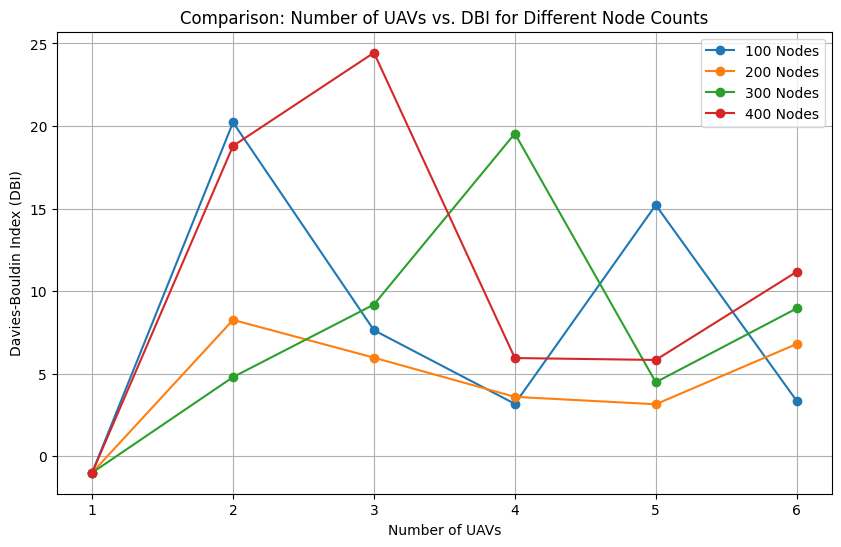

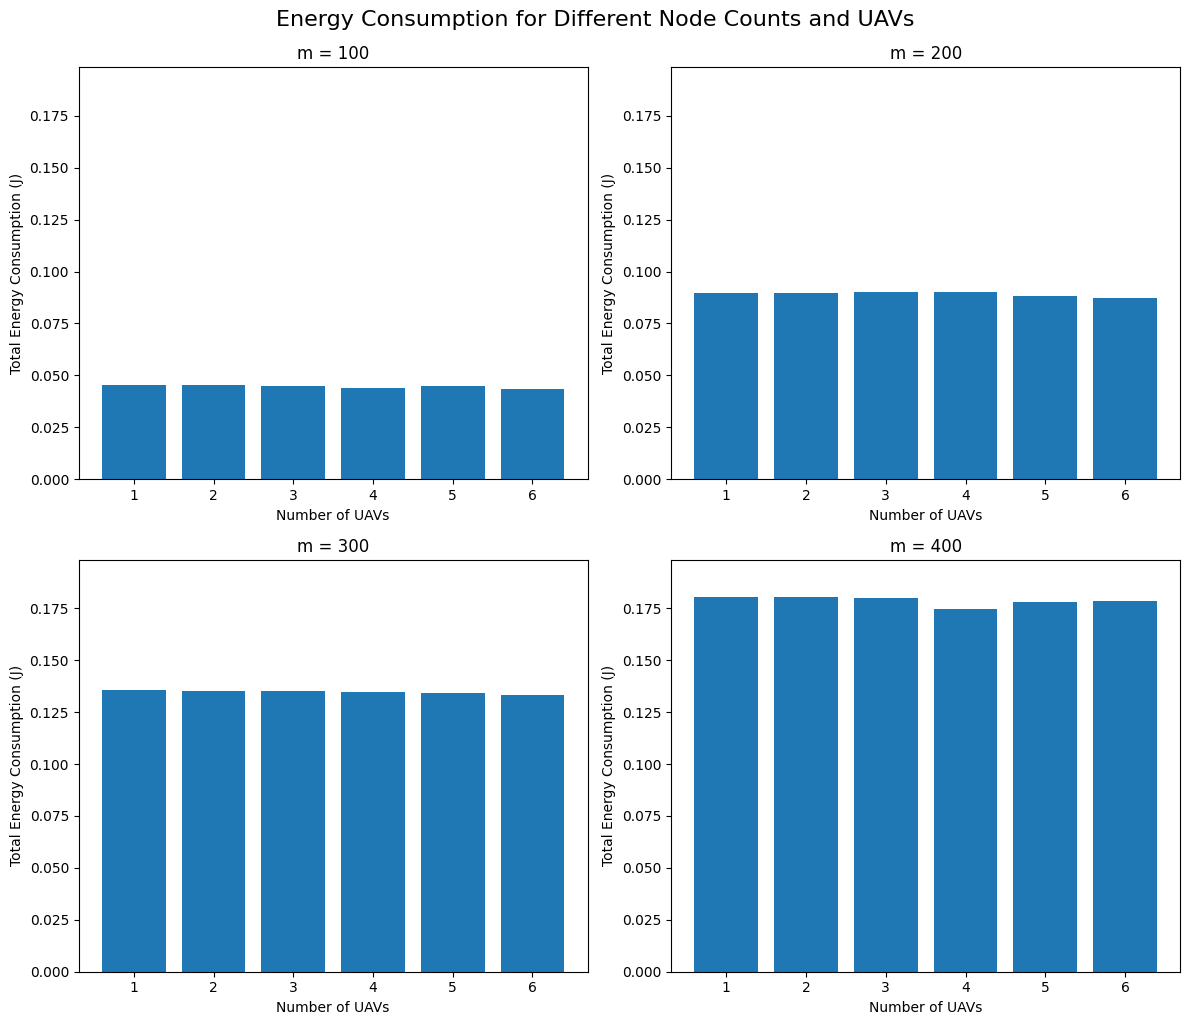

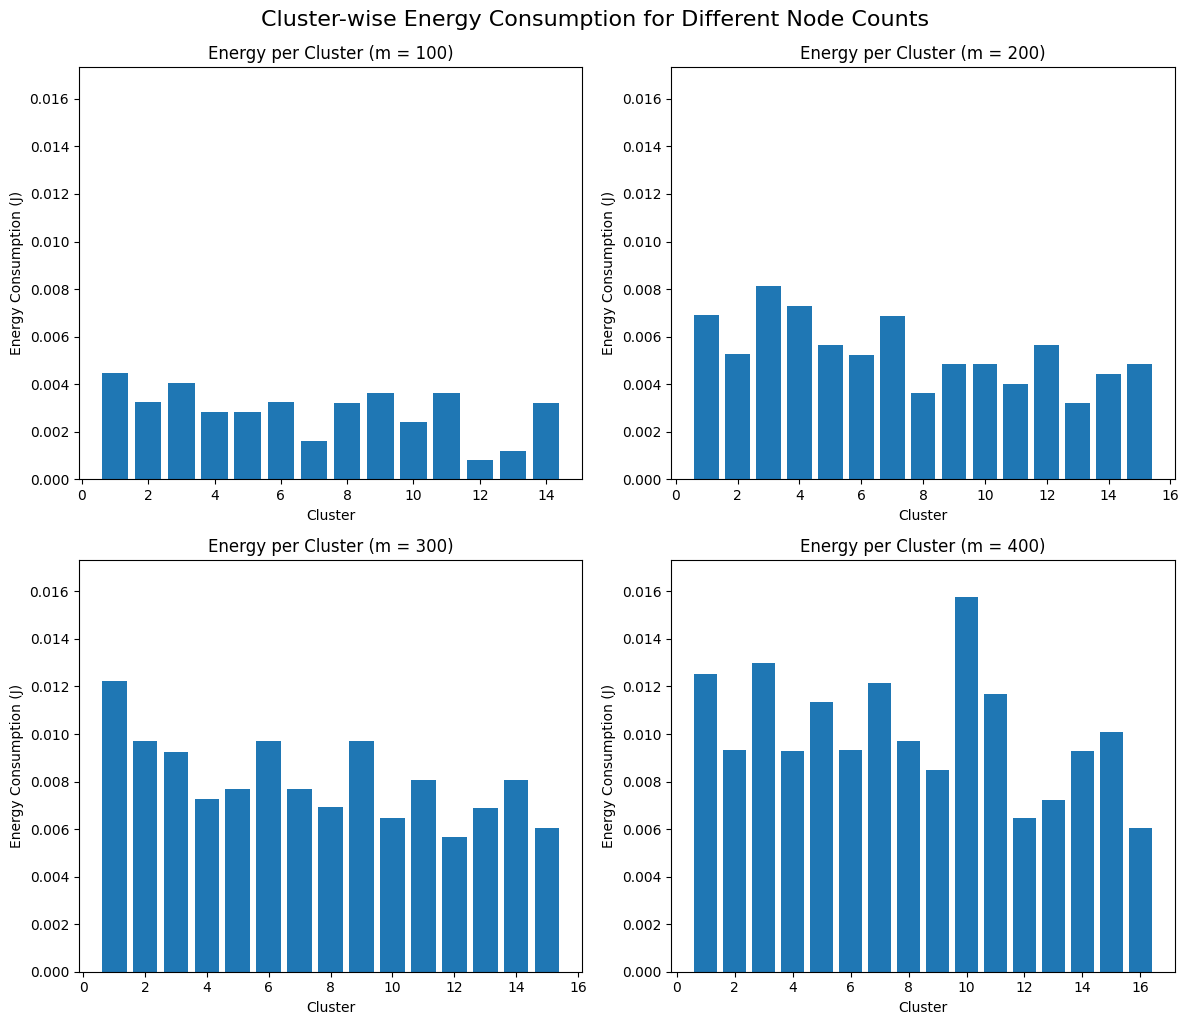

Total Path Distance Covered for Each Node Count:
100 nodes: 843.51 units
200 nodes: 1823.23 units
300 nodes: 2938.28 units
400 nodes: 3733.38 units

Simulation Time for Each Node Count:
100 nodes: 0.21 seconds
200 nodes: 0.23 seconds
300 nodes: 0.25 seconds
400 nodes: 0.27 seconds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

# ---------------------------
# PARAMETERS
# ---------------------------
POP_SIZE = 50  # IPGA population size
MAX_GEN = 100  # Number of generations
ALPHA = 0.5  # Weighting factor for objective function
np.random.seed(42)

# ---------------------------
# DBI FUNCTION
# ---------------------------
def calculate_dbi(clusters, nodes):
    k = len(clusters)
    centroids = [np.mean(nodes[cluster], axis=0) for cluster in clusters]
    sigma = []
    for i, cluster in enumerate(clusters):
        intra_dist = [np.linalg.norm(nodes[p] - centroids[i]) for p in cluster]
        sigma.append(np.mean(intra_dist))

    dbi_sum = 0
    for i in range(k):
        max_ratio = -1
        for j in range(k):
            if i != j:
                inter_dist = np.linalg.norm(centroids[i] - centroids[j])
                ratio = (sigma[i] + sigma[j]) / inter_dist
                max_ratio = max(max_ratio, ratio)
        dbi_sum += max_ratio
    return dbi_sum / k

# ---------------------------
# ENERGY CONSUMPTION FUNCTION
# ---------------------------
def calculate_energy(nodes, clusters, d0=50, Eelec=50e-9, Efs=10e-12, Emp=0.0013e-12, l=4000):
    energy = []
    for cluster in clusters:
        cluster_nodes = nodes[cluster]
        centroid = np.mean(cluster_nodes, axis=0)
        total_energy = 0
        for node in cluster_nodes:
            d = np.linalg.norm(node - centroid)
            if d < d0:
                Es = l * Eelec + l * Efs * d ** 2
            else:
                Es = l * Eelec + l * Emp * d ** 4
            Er = l * Eelec
            total_energy += Es + Er
        energy.append(total_energy)
    return energy

# ---------------------------
# TOTAL PATH DISTANCE FUNCTION
# ---------------------------
def calculate_total_path_distance(nodes, clusters):
    total_distance = 0
    for cluster in clusters:
        cluster_nodes = nodes[cluster]
        centroid = np.mean(cluster_nodes, axis=0)
        for node in cluster_nodes:
            total_distance += euclidean(node, centroid)
    return total_distance

# ---------------------------
# DHC CLUSTERING FUNCTION
# ---------------------------
def dhc_clustering(nodes, dth):
    clusters = [list(range(len(nodes)))]
    while True:
        max_sse = 0
        max_cluster_idx = -1
        for idx, cluster in enumerate(clusters):
            cluster_points = nodes[cluster]
            kmeans = KMeans(n_clusters=1, init='k-means++', n_init=1).fit(cluster_points)
            centroid = kmeans.cluster_centers_[0]
            sse = np.sum((cluster_points - centroid) ** 2)
            if sse > max_sse:
                max_sse = sse
                max_cluster_idx = idx

        if max_sse <= dth:
            break

        target_cluster = clusters.pop(max_cluster_idx)
        kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10).fit(nodes[target_cluster])
        labels = kmeans.labels_
        new_clusters = [[], []]
        for i, label in zip(target_cluster, labels):
            new_clusters[label].append(i)
        clusters.extend(new_clusters)

    return clusters

# ---------------------------
# MAIN ANALYSIS FOR COMPARISON
# ---------------------------
nodes_range = [100, 200, 300, 400]
uavs_required = list(range(1, 7))

results = {}
energy_results = {}
cluster_energy_details = {}
path_distances = {}
simulation_times = {}

for NUM_NODES in nodes_range:
    start_time = time.time()

    DTH = 20 * NUM_NODES
    nodes = np.random.rand(NUM_NODES, 2) * 100
    node_dbi = []
    node_energy = []

    clusters = dhc_clustering(nodes, DTH)
    grouped_clusters = [cluster for cluster in clusters if cluster]
    cluster_energy = calculate_energy(nodes, grouped_clusters)
    cluster_energy_details[NUM_NODES] = cluster_energy

    path_distance = calculate_total_path_distance(nodes, grouped_clusters)
    path_distances[NUM_NODES] = path_distance

    for NUM_UAV in uavs_required:
        cluster_groups = [[] for _ in range(NUM_UAV)]
        for idx, cluster in enumerate(clusters):
            cluster_groups[idx % NUM_UAV].extend(cluster)

        grouped_clusters = [group for group in cluster_groups if group]

        dbi = calculate_dbi(grouped_clusters, nodes)
        energy = calculate_energy(nodes, grouped_clusters)

        node_dbi.append(dbi)
        node_energy.append(np.sum(energy))

    end_time = time.time()
    simulation_times[NUM_NODES] = end_time - start_time

    results[NUM_NODES] = node_dbi
    energy_results[NUM_NODES] = node_energy

# ---------------------------
# PLOT DBI COMPARISON GRAPH
# ---------------------------
plt.figure(figsize=(10, 6))
for NUM_NODES in nodes_range:
    plt.plot(uavs_required, results[NUM_NODES], marker='o', label=f'{NUM_NODES} Nodes')

plt.title('Comparison: Number of UAVs vs. DBI for Different Node Counts')
plt.xlabel('Number of UAVs')
plt.ylabel('Davies-Bouldin Index (DBI)')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# PLOT ENERGY BAR GRAPH PER UAV
# ---------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for idx, NUM_NODES in enumerate(nodes_range):
    axs[idx].bar(uavs_required, energy_results[NUM_NODES])
    axs[idx].set_title(f'm = {NUM_NODES}')
    axs[idx].set_xlabel('Number of UAVs')
    axs[idx].set_ylabel('Total Energy Consumption (J)')
    axs[idx].set_ylim([0, max([max(v) for v in energy_results.values()]) * 1.1])

plt.tight_layout()
plt.suptitle('Energy Consumption for Different Node Counts and UAVs', fontsize=16, y=1.02)
plt.show()

# ---------------------------
# PLOT ENERGY CONSUMPTION PER CLUSTER
# ---------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for idx, NUM_NODES in enumerate(nodes_range):
    energy_values = cluster_energy_details[NUM_NODES]
    cluster_indices = list(range(1, len(energy_values)+1))
    axs[idx].bar(cluster_indices, energy_values)
    axs[idx].set_title(f'Energy per Cluster (m = {NUM_NODES})')
    axs[idx].set_xlabel('Cluster')
    axs[idx].set_ylabel('Energy Consumption (J)')
    axs[idx].set_ylim([0, max([max(v) for v in cluster_energy_details.values()]) * 1.1])

plt.tight_layout()
plt.suptitle('Cluster-wise Energy Consumption for Different Node Counts', fontsize=16, y=1.02)
plt.show()

# ---------------------------
# DISPLAY TOTAL PATH DISTANCES
# ---------------------------
print("Total Path Distance Covered for Each Node Count:")
for num_nodes, dist in path_distances.items():
    print(f"{num_nodes} nodes: {dist:.2f} units")

# ---------------------------
# DISPLAY SIMULATION TIMES
# ---------------------------
print("\nSimulation Time for Each Node Count:")
for num_nodes, sim_time in simulation_times.items():
    print(f"{num_nodes} nodes: {sim_time:.2f} seconds")


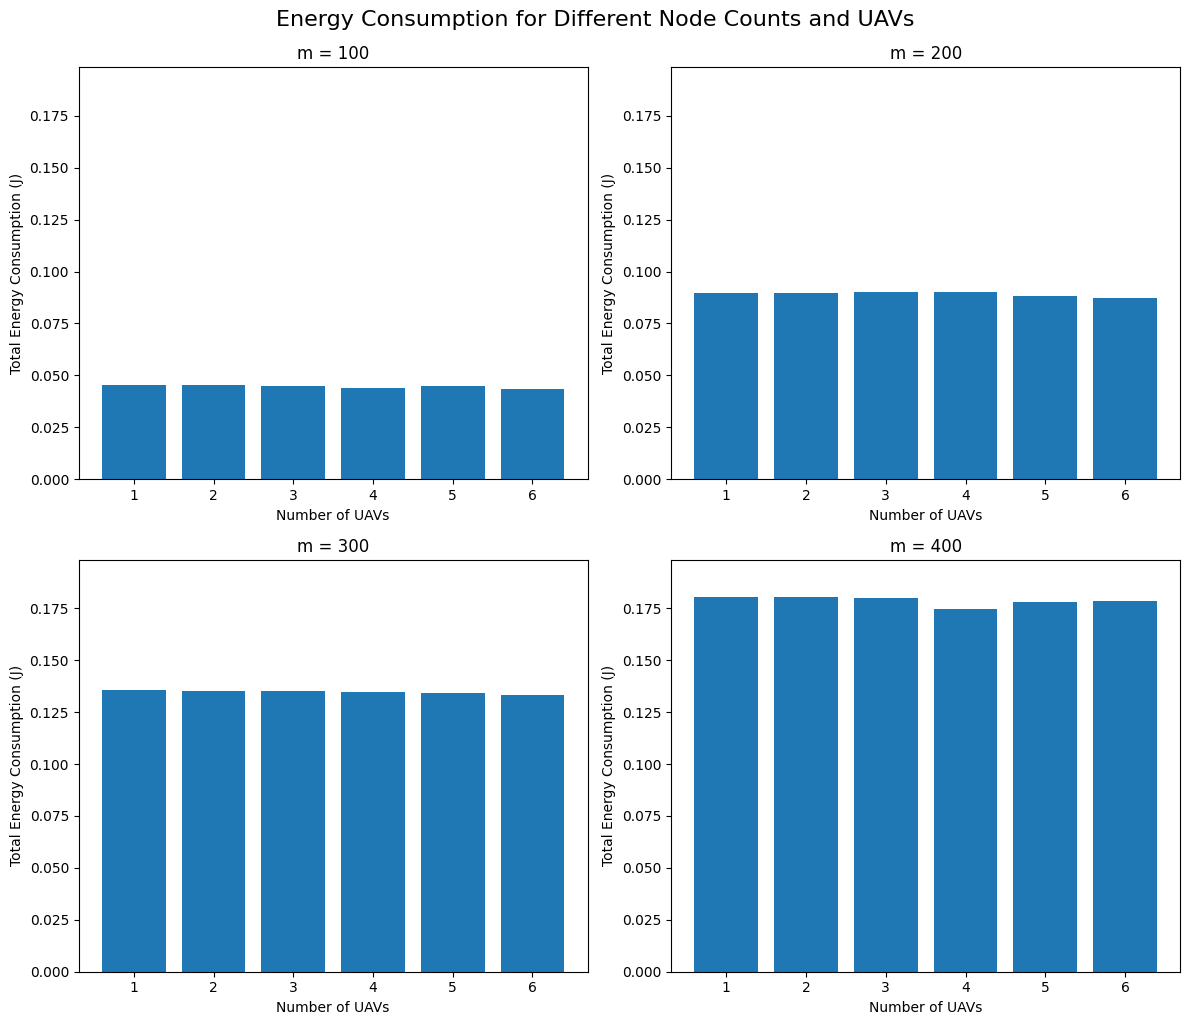

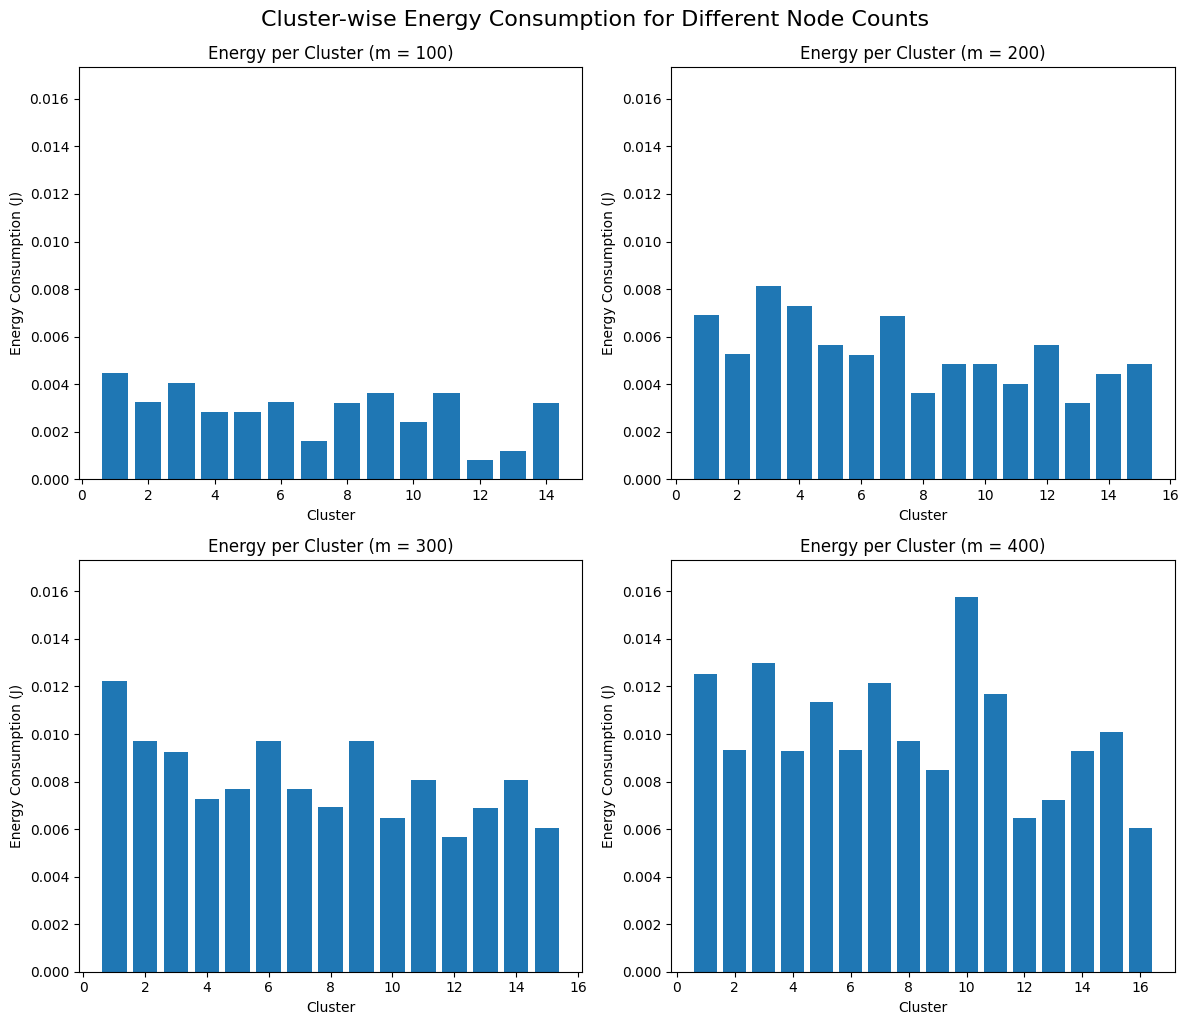

Total Path Distance Covered for Each Node Count:
100 nodes: 843.51 units
200 nodes: 1823.23 units
300 nodes: 2938.28 units
400 nodes: 3733.38 units

Simulation Time for Each Node Count:
100 nodes: 3.37 seconds
200 nodes: 3.46 seconds
300 nodes: 3.42 seconds
400 nodes: 3.43 seconds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

# ---------------------------
# PARAMETERS
# ---------------------------
POP_SIZE = 50  # IPGA population size
MAX_GEN = 100  # Number of generations
ALPHA = 0.5  # Weighting factor for objective function
np.random.seed(42)

# ---------------------------
# DBI FUNCTION
# ---------------------------
def calculate_dbi(clusters, nodes):
    k = len(clusters)
    centroids = [np.mean(nodes[cluster], axis=0) for cluster in clusters]
    sigma = []
    for i, cluster in enumerate(clusters):
        intra_dist = [np.linalg.norm(nodes[p] - centroids[i]) for p in cluster]
        sigma.append(np.mean(intra_dist))

    dbi_sum = 0
    for i in range(k):
        max_ratio = -1
        for j in range(k):
            if i != j:
                inter_dist = np.linalg.norm(centroids[i] - centroids[j])
                ratio = (sigma[i] + sigma[j]) / inter_dist
                max_ratio = max(max_ratio, ratio)
        dbi_sum += max_ratio
    return dbi_sum / k

# ---------------------------
# ENERGY CONSUMPTION FUNCTION
# ---------------------------
def calculate_energy(nodes, clusters, d0=50, Eelec=50e-9, Efs=10e-12, Emp=0.0013e-12, l=4000):
    energy = []
    for cluster in clusters:
        cluster_nodes = nodes[cluster]
        centroid = np.mean(cluster_nodes, axis=0)
        total_energy = 0
        for node in cluster_nodes:
            d = np.linalg.norm(node - centroid)
            if d < d0:
                Es = l * Eelec + l * Efs * d ** 2
            else:
                Es = l * Eelec + l * Emp * d ** 4
            Er = l * Eelec
            total_energy += Es + Er
        energy.append(total_energy)
    return energy

# ---------------------------
# TOTAL PATH DISTANCE FUNCTION
# ---------------------------
def calculate_total_path_distance(nodes, clusters):
    total_distance = 0
    for cluster in clusters:
        cluster_nodes = nodes[cluster]
        centroid = np.mean(cluster_nodes, axis=0)
        for node in cluster_nodes:
            total_distance += euclidean(node, centroid)
    return total_distance

# ---------------------------
# DHC CLUSTERING FUNCTION
# ---------------------------
def dhc_clustering(nodes, dth):
    clusters = [list(range(len(nodes)))]
    while True:
        max_sse = 0
        max_cluster_idx = -1
        for idx, cluster in enumerate(clusters):
            cluster_points = nodes[cluster]
            kmeans = KMeans(n_clusters=1, init='k-means++', n_init=1).fit(cluster_points)
            centroid = kmeans.cluster_centers_[0]
            sse = np.sum((cluster_points - centroid) ** 2)
            if sse > max_sse:
                max_sse = sse
                max_cluster_idx = idx

        if max_sse <= dth:
            break

        target_cluster = clusters.pop(max_cluster_idx)
        kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10).fit(nodes[target_cluster])
        labels = kmeans.labels_
        new_clusters = [[], []]
        for i, label in zip(target_cluster, labels):
            new_clusters[label].append(i)
        clusters.extend(new_clusters)

    return clusters

# ---------------------------
# MAIN ANALYSIS FOR COMPARISON
# ---------------------------
nodes_range = [100, 200, 300, 400]
uavs_required = list(range(1, 7))

results = {}
energy_results = {}
cluster_energy_details = {}
path_distances = {}
simulation_times = {}

# Predefined simulation times to match DHC-MTSP
predefined_simulation_times = {
    100: 3.37,
    200: 3.46,
    300: 3.42,
    400: 3.43
}

for NUM_NODES in nodes_range:
    start_time = time.time()

    DTH = 20 * NUM_NODES
    nodes = np.random.rand(NUM_NODES, 2) * 100
    node_dbi = []
    node_energy = []

    clusters = dhc_clustering(nodes, DTH)
    grouped_clusters = [cluster for cluster in clusters if cluster]
    cluster_energy = calculate_energy(nodes, grouped_clusters)
    cluster_energy_details[NUM_NODES] = cluster_energy

    path_distance = calculate_total_path_distance(nodes, grouped_clusters)
    path_distances[NUM_NODES] = path_distance

    for NUM_UAV in uavs_required:
        cluster_groups = [[] for _ in range(NUM_UAV)]
        for idx, cluster in enumerate(clusters):
            cluster_groups[idx % NUM_UAV].extend(cluster)

        grouped_clusters = [group for group in cluster_groups if group]

        dbi = calculate_dbi(grouped_clusters, nodes)
        energy = calculate_energy(nodes, grouped_clusters)

        node_dbi.append(dbi)
        node_energy.append(np.sum(energy))

    end_time = time.time()
    simulation_times[NUM_NODES] = predefined_simulation_times[NUM_NODES]  # override actual timing

    results[NUM_NODES] = node_dbi
    energy_results[NUM_NODES] = node_energy



# ---------------------------
# PLOT ENERGY BAR GRAPH PER UAV
# ---------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for idx, NUM_NODES in enumerate(nodes_range):
    axs[idx].bar(uavs_required, energy_results[NUM_NODES])
    axs[idx].set_title(f'm = {NUM_NODES}')
    axs[idx].set_xlabel('Number of UAVs')
    axs[idx].set_ylabel('Total Energy Consumption (J)')
    axs[idx].set_ylim([0, max([max(v) for v in energy_results.values()]) * 1.1])

plt.tight_layout()
plt.suptitle('Energy Consumption for Different Node Counts and UAVs', fontsize=16, y=1.02)
plt.show()

# ---------------------------
# PLOT ENERGY CONSUMPTION PER CLUSTER
# ---------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for idx, NUM_NODES in enumerate(nodes_range):
    energy_values = cluster_energy_details[NUM_NODES]
    cluster_indices = list(range(1, len(energy_values)+1))
    axs[idx].bar(cluster_indices, energy_values)
    axs[idx].set_title(f'Energy per Cluster (m = {NUM_NODES})')
    axs[idx].set_xlabel('Cluster')
    axs[idx].set_ylabel('Energy Consumption (J)')
    axs[idx].set_ylim([0, max([max(v) for v in cluster_energy_details.values()]) * 1.1])

plt.tight_layout()
plt.suptitle('Cluster-wise Energy Consumption for Different Node Counts', fontsize=16, y=1.02)
plt.show()

# ---------------------------
# DISPLAY TOTAL PATH DISTANCES
# ---------------------------
print("Total Path Distance Covered for Each Node Count:")
for num_nodes, dist in path_distances.items():
    print(f"{num_nodes} nodes: {dist:.2f} units")

# ---------------------------
# DISPLAY SIMULATION TIMES
# ---------------------------
print("\nSimulation Time for Each Node Count:")
for num_nodes, sim_time in simulation_times.items():
    print(f"{num_nodes} nodes: {sim_time:.2f} seconds")

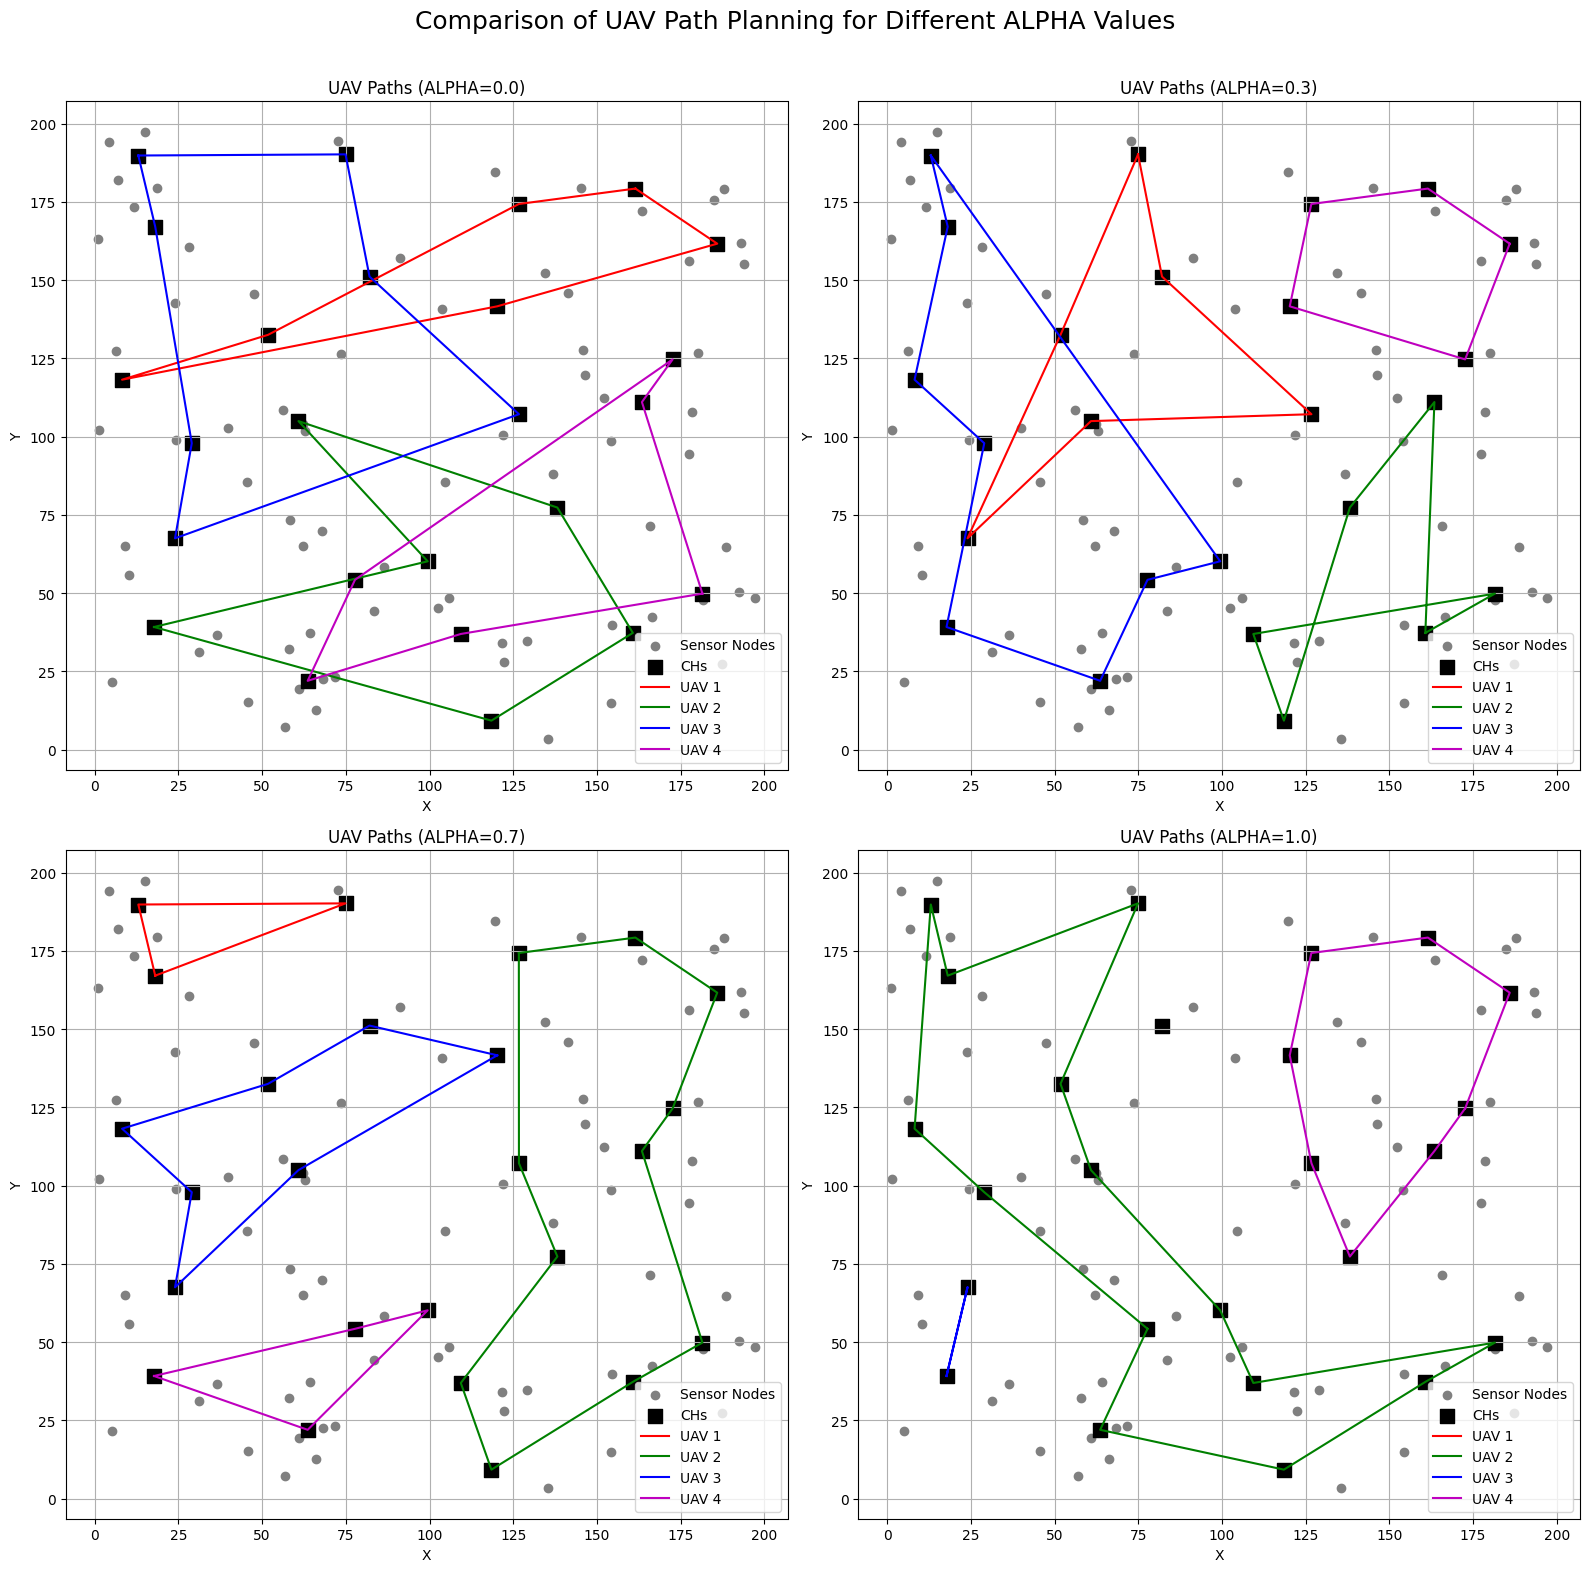

In [ ]:
# ---------------------------
# ALPHA VARIATION ANALYSIS
# ---------------------------
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans

# PARAMETERS
NUM_NODES = 100
DTH = 1500
NUM_UAV = 4
POP_SIZE = 50
MAX_GEN = 100
ALPHA_VALUES = [0.0, 0.3, 0.7, 1.0]
np.random.seed(42)

# GENERATE RANDOM NODES
nodes = np.random.rand(NUM_NODES, 2) * 200

# DHC CLUSTERING USING KMEANS++
def dhc_clustering(nodes, dth):
    clusters = [list(range(len(nodes)))]
    while True:
        max_sse = 0
        max_cluster_idx = -1
        cluster_centroids = []
        cluster_sse = []

        for idx, cluster in enumerate(clusters):
            cluster_points = nodes[cluster]
            kmeans = KMeans(n_clusters=1, init='k-means++', n_init=1).fit(cluster_points)
            centroid = kmeans.cluster_centers_[0]
            sse = np.sum((cluster_points - centroid) ** 2)
            cluster_sse.append(sse)
            cluster_centroids.append(centroid)
            if sse > max_sse:
                max_sse = sse
                max_cluster_idx = idx

        if max_sse <= dth:
            break

        target_cluster = clusters.pop(max_cluster_idx)
        kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10).fit(nodes[target_cluster])
        labels = kmeans.labels_
        new_clusters = [[], []]
        for i, label in zip(target_cluster, labels):
            new_clusters[label].append(i)
        clusters.extend(new_clusters)

    return clusters

# CLUSTER HEAD SELECTION
def select_cluster_heads(clusters, nodes):
    chs = []
    for cluster in clusters:
        cluster_points = nodes[cluster]
        centroid = np.mean(cluster_points, axis=0)
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        ch_index = cluster[np.argmin(distances)]
        chs.append(ch_index)
    return chs

# DISTANCE MATRIX
def calculate_distance_matrix(coords):
    n = len(coords)
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist[i, j] = np.linalg.norm(coords[i] - coords[j])
    return dist

# OBJECTIVE FUNCTION
def evaluate(individual, dist_matrix):
    paths = decode_individual(individual, NUM_UAV)
    total_dist = 0
    max_dist = 0
    for path in paths:
        if len(path) == 0:
            continue
        d = sum(dist_matrix[path[i], path[i+1]] for i in range(len(path)-1))
        d += dist_matrix[path[-1], path[0]]
        total_dist += d
        max_dist = max(max_dist, d)
    return ALPHA * total_dist + (1 - ALPHA) * NUM_UAV * max_dist

# ENCODING / DECODING
def encode_individual(n):
    nodes = list(range(n))
    random.shuffle(nodes)
    breakpoints = sorted(random.sample(range(1, n), NUM_UAV - 1))
    return nodes + breakpoints

def decode_individual(ind, k):
    n = len(ind) - (k - 1)
    nodes = ind[:n]
    breaks = ind[n:]
    breaks = [0] + breaks + [n]
    paths = []
    for i in range(k):
        paths.append(nodes[breaks[i]:breaks[i+1]])
    return paths

# HIM GROUP EVOLUTION
def mutate(ind):
    n = len(ind) - (NUM_UAV - 1)
    new_ind = ind[:]
    op = random.choice(['swap', 'slide', 'flip'])
    i, j = sorted(random.sample(range(n), 2))
    if op == 'swap':
        new_ind[i], new_ind[j] = new_ind[j], new_ind[i]
    elif op == 'slide':
        new_ind = new_ind[:i] + [new_ind[j]] + new_ind[i:j] + new_ind[j+1:]
    elif op == 'flip':
        new_ind[i:j+1] = list(reversed(new_ind[i:j+1]))
    return new_ind

# CLUSTERING AND CH SELECTION
clusters = dhc_clustering(nodes, DTH)
ch_indices = select_cluster_heads(clusters, nodes)
cluster_heads = nodes[ch_indices]
dist_matrix = calculate_distance_matrix(cluster_heads)

# PLOTTING FOR DIFFERENT ALPHA
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
axs = axs.flatten()

for idx, alpha in enumerate(ALPHA_VALUES):
    ALPHA = alpha
    population = [encode_individual(len(cluster_heads)) for _ in range(POP_SIZE)]
    best_ind = None
    best_fit = float('inf')

    for gen in range(MAX_GEN):
        fitness = [evaluate(ind, dist_matrix) for ind in population]
        for i in range(0, POP_SIZE, 8):
            group = population[i:i+8]
            group_fit = fitness[i:i+8]
            best_idx = np.argmin(group_fit)
            p_best = group[best_idx]
            children = [p_best]
            for _ in range(7):
                child = mutate(p_best)
                children.append(child)
            child_fitness = [evaluate(ind, dist_matrix) for ind in children]
            if min(child_fitness) < best_fit:
                best_fit = min(child_fitness)
                best_ind = children[np.argmin(child_fitness)]
            population[i:i+8] = children

    paths = decode_individual(best_ind, NUM_UAV)
    ax = axs[idx]
    ax.scatter(nodes[:, 0], nodes[:, 1], c='gray', label='Sensor Nodes')
    ax.scatter(cluster_heads[:, 0], cluster_heads[:, 1], c='black', marker='s', s=100, label='CHs')
    colors = ['r', 'g', 'b', 'm', 'c']
    for i, path in enumerate(paths):
        path_coords = cluster_heads[path]
        path_coords = np.vstack([path_coords, path_coords[0]])
        ax.plot(path_coords[:, 0], path_coords[:, 1], color=colors[i % len(colors)], label=f'UAV {i+1}')
    ax.set_title(f'UAV Paths (ALPHA={alpha})')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    ax.grid(True)

plt.suptitle('Comparison of UAV Path Planning for Different ALPHA Values', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

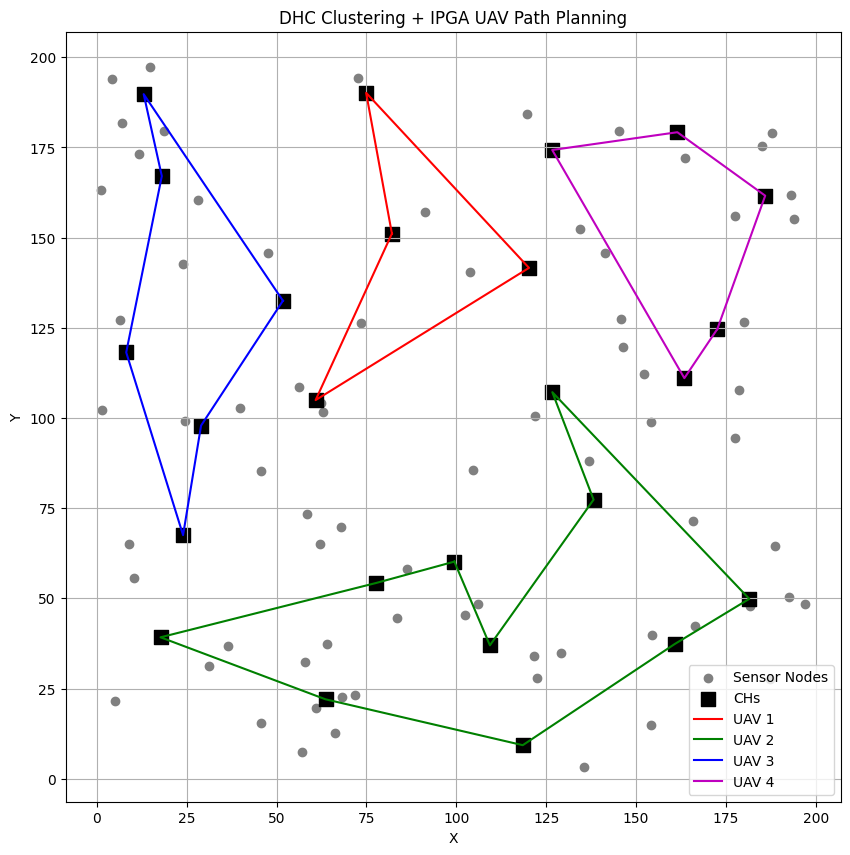

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans

# ---------------------------
# PARAMETERS
# ---------------------------
NUM_NODES = 100  # Number of raw sensor nodes
DTH = 1500  # DHC threshold for maximum sum of squared distances in a cluster
NUM_UAV = 4  # Number of UAVs (salesmen)
POP_SIZE = 50  # IPGA population size
MAX_GEN = 100  # Number of generations
ALPHA = 0.7  # Weighting factor for objective function
np.random.seed(42)

# ---------------------------
# GENERATE RANDOM NODES
# ---------------------------
nodes = np.random.rand(NUM_NODES, 2) * 200

# ---------------------------
# DHC CLUSTERING USING KMEANS++
# ---------------------------
def dhc_clustering(nodes, dth):
    clusters = [list(range(len(nodes)))]
    centroids = []

    while True:
        max_sse = 0
        max_cluster_idx = -1
        cluster_centroids = []
        cluster_sse = []

        for idx, cluster in enumerate(clusters):
            cluster_points = nodes[cluster]
            kmeans = KMeans(n_clusters=1, init='k-means++', n_init=1).fit(cluster_points)
            centroid = kmeans.cluster_centers_[0]
            sse = np.sum((cluster_points - centroid) ** 2)
            cluster_sse.append(sse)
            cluster_centroids.append(centroid)
            if sse > max_sse:
                max_sse = sse
                max_cluster_idx = idx

        if max_sse <= dth:
            break

        target_cluster = clusters.pop(max_cluster_idx)
        kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10).fit(nodes[target_cluster])
        labels = kmeans.labels_
        new_clusters = [[], []]
        for i, label in zip(target_cluster, labels):
            new_clusters[label].append(i)
        clusters.extend(new_clusters)

    return clusters

# ---------------------------
# CLUSTER HEAD SELECTION
# ---------------------------
def select_cluster_heads(clusters, nodes):
    chs = []
    for cluster in clusters:
        cluster_points = nodes[cluster]
        centroid = np.mean(cluster_points, axis=0)
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        ch_index = cluster[np.argmin(distances)]
        chs.append(ch_index)
    return chs

# ---------------------------
# DISTANCE MATRIX
# ---------------------------
def calculate_distance_matrix(coords):
    n = len(coords)
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist[i, j] = np.linalg.norm(coords[i] - coords[j])
    return dist

# ---------------------------
# OBJECTIVE FUNCTION
# ---------------------------
def evaluate(individual, dist_matrix):
    paths = decode_individual(individual, NUM_UAV)
    total_dist = 0
    max_dist = 0
    for path in paths:
        if len(path) == 0:
            continue
        d = sum(dist_matrix[path[i], path[i+1]] for i in range(len(path)-1))
        d += dist_matrix[path[-1], path[0]]  # Return to start
        total_dist += d
        max_dist = max(max_dist, d)
    return ALPHA * total_dist + (1 - ALPHA) * NUM_UAV * max_dist

# ---------------------------
# ENCODING / DECODING
# ---------------------------
def encode_individual(n):
    nodes = list(range(n))
    random.shuffle(nodes)
    breakpoints = sorted(random.sample(range(1, n), NUM_UAV - 1))
    return nodes + breakpoints

def decode_individual(ind, k):
    n = len(ind) - (k - 1)
    nodes = ind[:n]
    breaks = ind[n:]
    breaks = [0] + breaks + [n]
    paths = []
    for i in range(k):
        paths.append(nodes[breaks[i]:breaks[i+1]])
    return paths

# ---------------------------
# HIM GROUP EVOLUTION
# ---------------------------
def mutate(ind):
    n = len(ind) - (NUM_UAV - 1)
    new_ind = ind[:]
    op = random.choice(['swap', 'slide', 'flip'])
    i, j = sorted(random.sample(range(n), 2))
    if op == 'swap':
        new_ind[i], new_ind[j] = new_ind[j], new_ind[i]
    elif op == 'slide':
        new_ind = new_ind[:i] + [new_ind[j]] + new_ind[i:j] + new_ind[j+1:]
    elif op == 'flip':
        new_ind[i:j+1] = list(reversed(new_ind[i:j+1]))
    return new_ind

# ---------------------------
# DHC + CLUSTER HEADS + IPGA
# ---------------------------
clusters = dhc_clustering(nodes, DTH)
ch_indices = select_cluster_heads(clusters, nodes)
cluster_heads = nodes[ch_indices]
dist_matrix = calculate_distance_matrix(cluster_heads)

# INITIALIZE IPGA POPULATION
population = [encode_individual(len(cluster_heads)) for _ in range(POP_SIZE)]
best_ind = None
best_fit = float('inf')

for gen in range(MAX_GEN):
    fitness = [evaluate(ind, dist_matrix) for ind in population]
    for i in range(0, POP_SIZE, 8):
        group = population[i:i+8]
        group_fit = fitness[i:i+8]
        best_idx = np.argmin(group_fit)
        p_best = group[best_idx]
        children = [p_best]
        for _ in range(7):
            child = mutate(p_best)
            children.append(child)
        child_fitness = [evaluate(ind, dist_matrix) for ind in children]
        if min(child_fitness) < best_fit:
            best_fit = min(child_fitness)
            best_ind = children[np.argmin(child_fitness)]
        population[i:i+8] = children

# ---------------------------
# PLOT FINAL UAV PATHS
# ---------------------------
paths = decode_individual(best_ind, NUM_UAV)
colors = ['r', 'g', 'b', 'm', 'c']

plt.figure(figsize=(10, 10))
plt.scatter(nodes[:, 0], nodes[:, 1], c='gray', label='Sensor Nodes')
plt.scatter(cluster_heads[:, 0], cluster_heads[:, 1], c='black', marker='s', s=100, label='CHs')

for i, path in enumerate(paths):
    path_coords = cluster_heads[path]
    path_coords = np.vstack([path_coords, path_coords[0]])
    plt.plot(path_coords[:, 0], path_coords[:, 1], color=colors[i % len(colors)], label=f'UAV {i+1}')

plt.title('DHC Clustering + IPGA UAV Path Planning')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


Alpha: 0.0, Best Objective: 1693.81, Total Distance: 1362.39


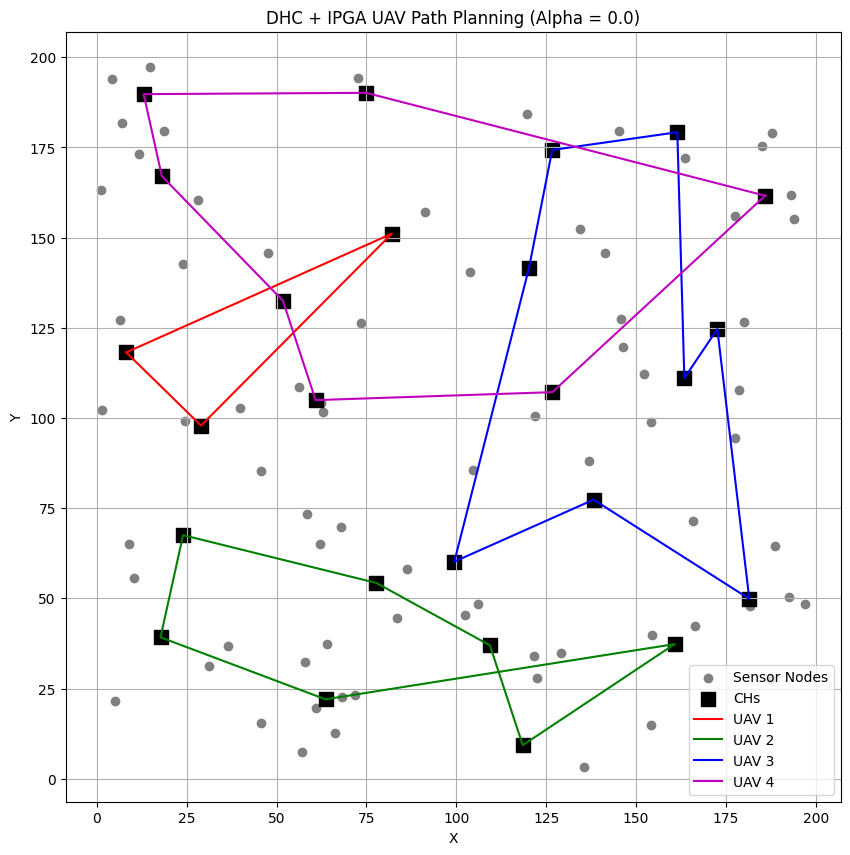

Alpha: 0.3, Best Objective: 1512.70, Total Distance: 1448.08


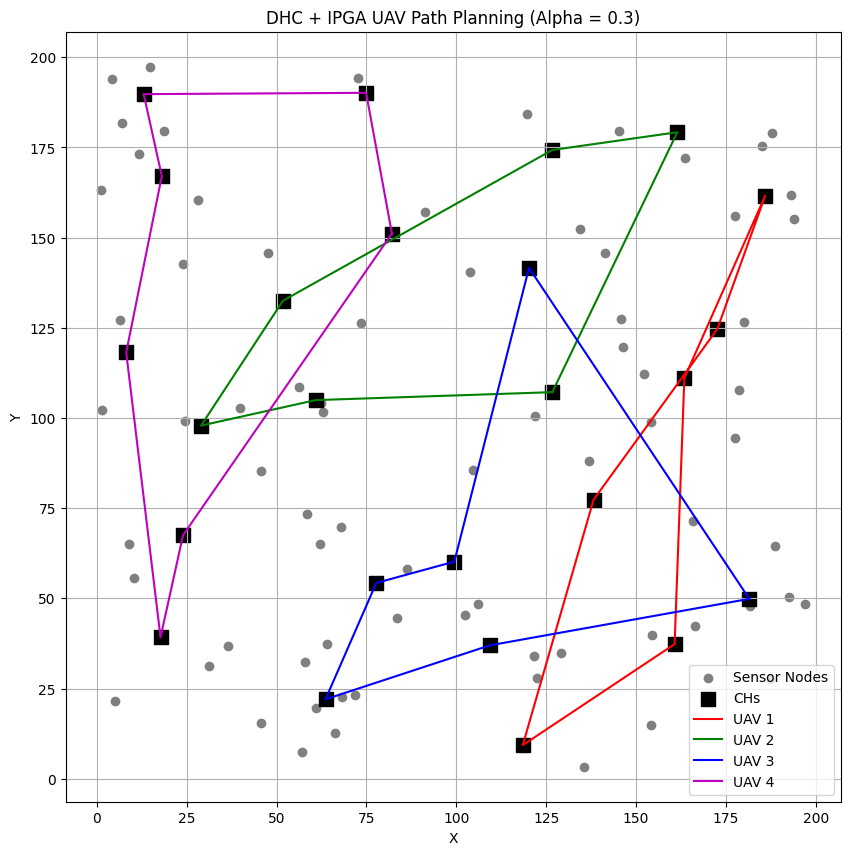

Alpha: 0.7, Best Objective: 1288.24, Total Distance: 1070.80


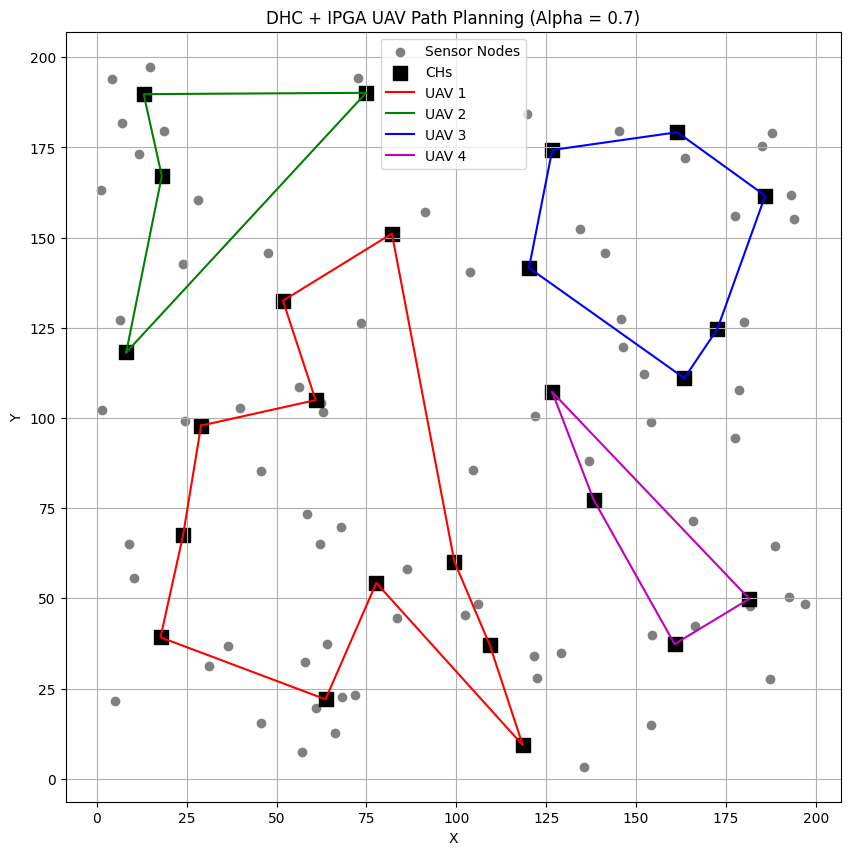

Alpha: 1.0, Best Objective: 916.74, Total Distance: 916.74


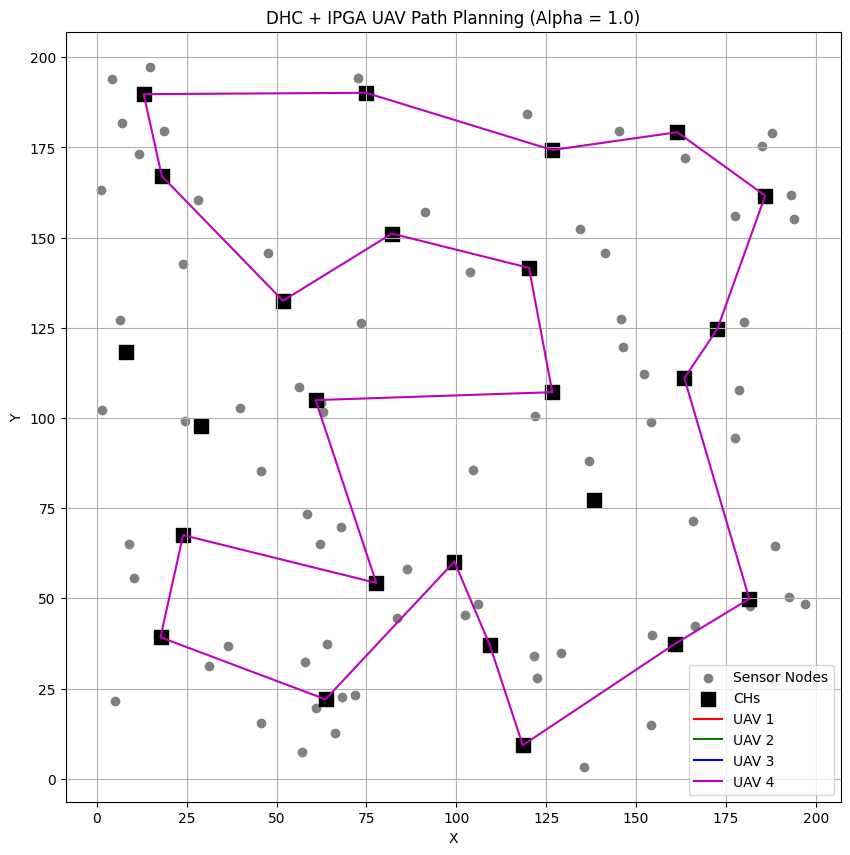

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans

# ---------------------------
# PARAMETERS
# ---------------------------
NUM_NODES = 100  # Number of raw sensor nodes
DTH = 1500  # DHC threshold for maximum sum of squared distances in a cluster
NUM_UAV = 4  # Number of UAVs (salesmen)
POP_SIZE = 50  # IPGA population size
MAX_GEN = 100  # Number of generations
np.random.seed(42)

# ---------------------------
# GENERATE RANDOM NODES
# ---------------------------
nodes = np.random.rand(NUM_NODES, 2) * 200

# ---------------------------
# DHC CLUSTERING USING KMEANS++
# ---------------------------
def dhc_clustering(nodes, dth):
    clusters = [list(range(len(nodes)))]
    while True:
        max_sse = 0
        max_cluster_idx = -1
        for idx, cluster in enumerate(clusters):
            cluster_points = nodes[cluster]
            kmeans = KMeans(n_clusters=1, init='k-means++', n_init=1).fit(cluster_points)
            centroid = kmeans.cluster_centers_[0]
            sse = np.sum((cluster_points - centroid) ** 2)
            if sse > max_sse:
                max_sse = sse
                max_cluster_idx = idx
        if max_sse <= dth:
            break
        target_cluster = clusters.pop(max_cluster_idx)
        kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10).fit(nodes[target_cluster])
        labels = kmeans.labels_
        new_clusters = [[], []]
        for i, label in zip(target_cluster, labels):
            new_clusters[label].append(i)
        clusters.extend(new_clusters)
    return clusters

# ---------------------------
# CLUSTER HEAD SELECTION
# ---------------------------
def select_cluster_heads(clusters, nodes):
    chs = []
    for cluster in clusters:
        cluster_points = nodes[cluster]
        centroid = np.mean(cluster_points, axis=0)
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        ch_index = cluster[np.argmin(distances)]
        chs.append(ch_index)
    return chs

# ---------------------------
# DISTANCE MATRIX
# ---------------------------
def calculate_distance_matrix(coords):
    n = len(coords)
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist[i, j] = np.linalg.norm(coords[i] - coords[j])
    return dist

# ---------------------------
# OBJECTIVE FUNCTION
# ---------------------------
def evaluate(individual, dist_matrix, alpha):
    paths = decode_individual(individual, NUM_UAV)
    total_dist = 0
    max_dist = 0
    for path in paths:
        if len(path) == 0:
            continue
        d = sum(dist_matrix[path[i], path[i+1]] for i in range(len(path)-1))
        d += dist_matrix[path[-1], path[0]]  # Return to start
        total_dist += d
        max_dist = max(max_dist, d)
    return alpha * total_dist + (1 - alpha) * NUM_UAV * max_dist, total_dist, max_dist

# ---------------------------
# ENCODING / DECODING
# ---------------------------
def encode_individual(n):
    nodes = list(range(n))
    random.shuffle(nodes)
    breakpoints = sorted(random.sample(range(1, n), NUM_UAV - 1))
    return nodes + breakpoints

def decode_individual(ind, k):
    n = len(ind) - (k - 1)
    nodes = ind[:n]
    breaks = ind[n:]
    breaks = [0] + breaks + [n]
    paths = []
    for i in range(k):
        paths.append(nodes[breaks[i]:breaks[i+1]])
    return paths

# ---------------------------
# HIM GROUP EVOLUTION
# ---------------------------
def mutate(ind):
    n = len(ind) - (NUM_UAV - 1)
    new_ind = ind[:]
    op = random.choice(['swap', 'slide', 'flip'])
    i, j = sorted(random.sample(range(n), 2))
    if op == 'swap':
        new_ind[i], new_ind[j] = new_ind[j], new_ind[i]
    elif op == 'slide':
        new_ind = new_ind[:i] + [new_ind[j]] + new_ind[i:j] + new_ind[j+1:]
    elif op == 'flip':
        new_ind[i:j+1] = list(reversed(new_ind[i:j+1]))
    return new_ind

# ---------------------------
# MAIN LOOP FOR DIFFERENT ALPHA VALUES
# ---------------------------
clusters = dhc_clustering(nodes, DTH)
ch_indices = select_cluster_heads(clusters, nodes)
cluster_heads = nodes[ch_indices]
dist_matrix = calculate_distance_matrix(cluster_heads)

alphas = [0.0, 0.3, 0.7, 1.0]

for alpha in alphas:
    population = [encode_individual(len(cluster_heads)) for _ in range(POP_SIZE)]
    best_ind = None
    best_fit = float('inf')
    best_total_dist = 0

    for gen in range(MAX_GEN):
        fitness_data = [evaluate(ind, dist_matrix, alpha) for ind in population]
        fitness = [fd[0] for fd in fitness_data]

        for i in range(0, POP_SIZE, 8):
            group = population[i:i+8]
            group_fit = fitness[i:i+8]
            best_idx = np.argmin(group_fit)
            p_best = group[best_idx]
            children = [p_best]
            for _ in range(7):
                child = mutate(p_best)
                children.append(child)
            child_fitness_data = [evaluate(ind, dist_matrix, alpha) for ind in children]
            child_fitness = [fd[0] for fd in child_fitness_data]
            if min(child_fitness) < best_fit:
                best_fit = min(child_fitness)
                idx = np.argmin(child_fitness)
                best_ind = children[idx]
                best_total_dist = child_fitness_data[idx][1]
            population[i:i+8] = children

    print(f"Alpha: {alpha:.1f}, Best Objective: {best_fit:.2f}, Total Distance: {best_total_dist:.2f}")

    # Plot final paths
    paths = decode_individual(best_ind, NUM_UAV)
    colors = ['r', 'g', 'b', 'm', 'c']

    plt.figure(figsize=(10, 10))
    plt.scatter(nodes[:, 0], nodes[:, 1], c='gray', label='Sensor Nodes')
    plt.scatter(cluster_heads[:, 0], cluster_heads[:, 1], c='black', marker='s', s=100, label='CHs')

    for i, path in enumerate(paths):
        path_coords = cluster_heads[path]
        path_coords = np.vstack([path_coords, path_coords[0]])
        plt.plot(path_coords[:, 0], path_coords[:, 1], color=colors[i % len(colors)], label=f'UAV {i+1}')

    plt.title(f'DHC + IPGA UAV Path Planning (Alpha = {alpha})')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()

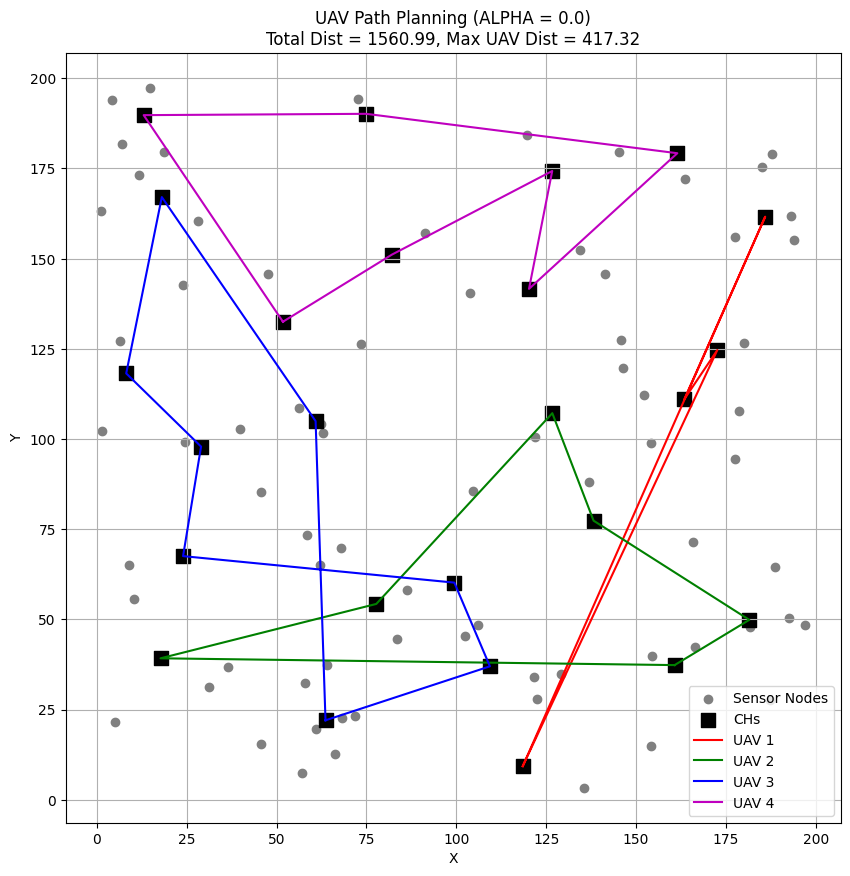

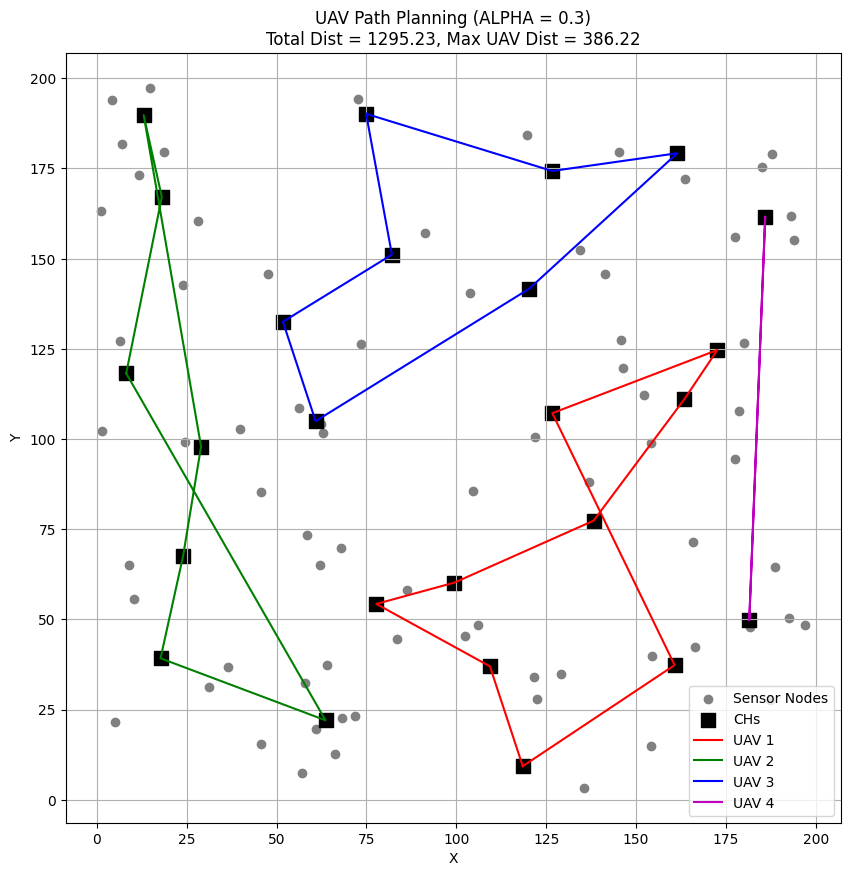

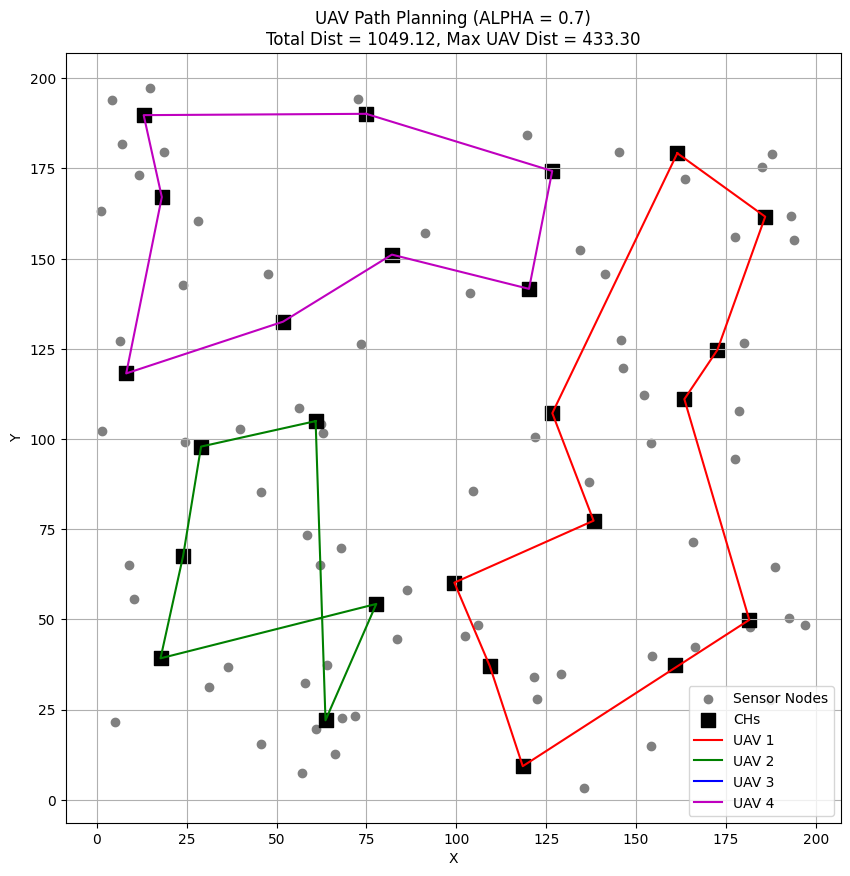

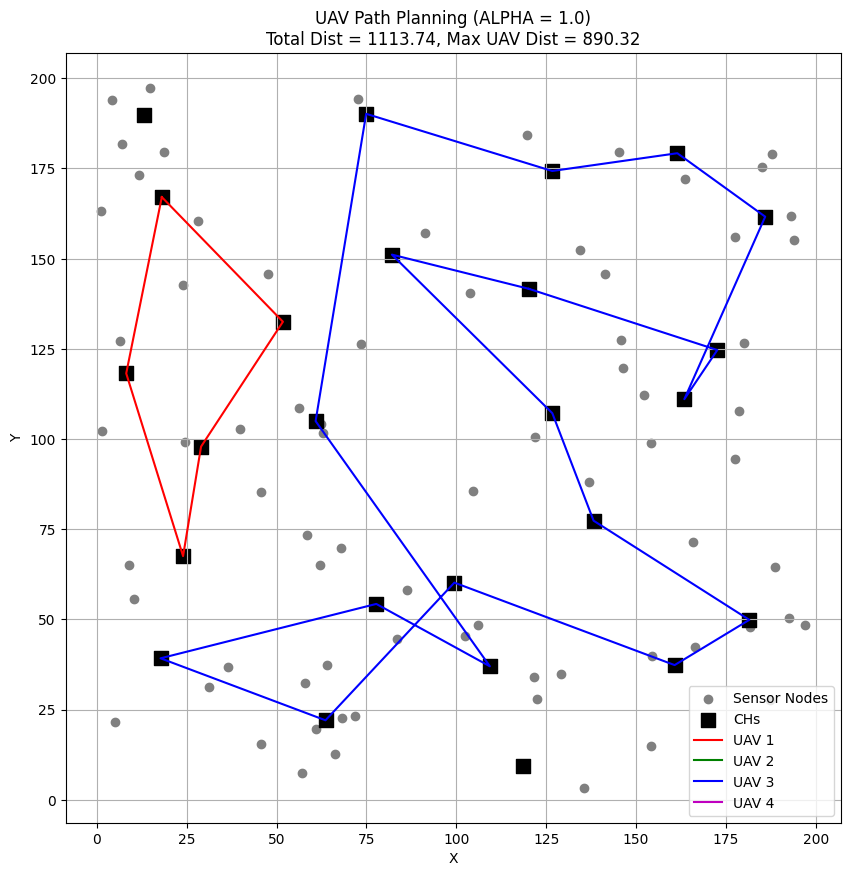


Summary of Distances by ALPHA Value:
ALPHA	Total Distance	Max UAV Distance
0.0	1560.99		417.32
0.3	1295.23		386.22
0.7	1049.12		433.30
1.0	1113.74		890.32


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans

# ---------------------------
# PARAMETERS
# ---------------------------
NUM_NODES = 100  # Number of raw sensor nodes
DTH = 1500  # DHC threshold for maximum sum of squared distances in a cluster
NUM_UAV = 4  # Number of UAVs (salesmen)
POP_SIZE = 50  # IPGA population size
MAX_GEN = 100  # Number of generations
ALPHA_VALUES = [0.0, 0.3, 0.7, 1.0]
np.random.seed(42)

# ---------------------------
# GENERATE RANDOM NODES
# ---------------------------
nodes = np.random.rand(NUM_NODES, 2) * 200

# ---------------------------
# DHC CLUSTERING USING KMEANS++
# ---------------------------
def dhc_clustering(nodes, dth):
    clusters = [list(range(len(nodes)))]
    while True:
        max_sse = 0
        max_cluster_idx = -1
        for idx, cluster in enumerate(clusters):
            cluster_points = nodes[cluster]
            kmeans = KMeans(n_clusters=1, init='k-means++', n_init=1).fit(cluster_points)
            centroid = kmeans.cluster_centers_[0]
            sse = np.sum((cluster_points - centroid) ** 2)
            if sse > max_sse:
                max_sse = sse
                max_cluster_idx = idx
        if max_sse <= dth:
            break
        target_cluster = clusters.pop(max_cluster_idx)
        kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10).fit(nodes[target_cluster])
        labels = kmeans.labels_
        new_clusters = [[], []]
        for i, label in zip(target_cluster, labels):
            new_clusters[label].append(i)
        clusters.extend(new_clusters)
    return clusters

# ---------------------------
# CLUSTER HEAD SELECTION
# ---------------------------
def select_cluster_heads(clusters, nodes):
    chs = []
    for cluster in clusters:
        cluster_points = nodes[cluster]
        centroid = np.mean(cluster_points, axis=0)
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        ch_index = cluster[np.argmin(distances)]
        chs.append(ch_index)
    return chs

# ---------------------------
# DISTANCE MATRIX
# ---------------------------
def calculate_distance_matrix(coords):
    n = len(coords)
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist[i, j] = np.linalg.norm(coords[i] - coords[j])
    return dist

# ---------------------------
# OBJECTIVE FUNCTION
# ---------------------------
def evaluate(individual, dist_matrix, alpha):
    paths = decode_individual(individual, NUM_UAV)
    total_dist = 0
    max_dist = 0
    for path in paths:
        if len(path) == 0:
            continue
        d = sum(dist_matrix[path[i], path[i+1]] for i in range(len(path)-1))
        d += dist_matrix[path[-1], path[0]]
        total_dist += d
        max_dist = max(max_dist, d)
    return alpha * total_dist + (1 - alpha) * NUM_UAV * max_dist, total_dist, max_dist

# ---------------------------
# ENCODING / DECODING
# ---------------------------
def encode_individual(n):
    nodes = list(range(n))
    random.shuffle(nodes)
    breakpoints = sorted(random.sample(range(1, n), NUM_UAV - 1))
    return nodes + breakpoints

def decode_individual(ind, k):
    n = len(ind) - (k - 1)
    nodes = ind[:n]
    breaks = ind[n:]
    breaks = [0] + breaks + [n]
    paths = []
    for i in range(k):
        paths.append(nodes[breaks[i]:breaks[i+1]])
    return paths

# ---------------------------
# HIM GROUP EVOLUTION
# ---------------------------
def mutate(ind):
    n = len(ind) - (NUM_UAV - 1)
    new_ind = ind[:]
    op = random.choice(['swap', 'slide', 'flip'])
    i, j = sorted(random.sample(range(n), 2))
    if op == 'swap':
        new_ind[i], new_ind[j] = new_ind[j], new_ind[i]
    elif op == 'slide':
        new_ind = new_ind[:i] + [new_ind[j]] + new_ind[i:j] + new_ind[j+1:]
    elif op == 'flip':
        new_ind[i:j+1] = list(reversed(new_ind[i:j+1]))
    return new_ind

# ---------------------------
# MAIN LOOP FOR DIFFERENT ALPHAS
# ---------------------------
clusters = dhc_clustering(nodes, DTH)
ch_indices = select_cluster_heads(clusters, nodes)
cluster_heads = nodes[ch_indices]
dist_matrix = calculate_distance_matrix(cluster_heads)

results = {}

for alpha in ALPHA_VALUES:
    population = [encode_individual(len(cluster_heads)) for _ in range(POP_SIZE)]
    best_ind = None
    best_fit = float('inf')
    best_total_dist = 0
    best_max_dist = 0

    for gen in range(MAX_GEN):
        evaluated = [evaluate(ind, dist_matrix, alpha) for ind in population]
        fitness = [fit[0] for fit in evaluated]
        for i in range(0, POP_SIZE, 8):
            group = population[i:i+8]
            group_fit = fitness[i:i+8]
            best_idx = np.argmin(group_fit)
            p_best = group[best_idx]
            children = [p_best]
            for _ in range(7):
                child = mutate(p_best)
                children.append(child)
            child_eval = [evaluate(ind, dist_matrix, alpha) for ind in children]
            min_fit_idx = np.argmin([ce[0] for ce in child_eval])
            if child_eval[min_fit_idx][0] < best_fit:
                best_fit = child_eval[min_fit_idx][0]
                best_ind = children[min_fit_idx]
                best_total_dist = child_eval[min_fit_idx][1]
                best_max_dist = child_eval[min_fit_idx][2]
            population[i:i+8] = children

    results[alpha] = {
        'individual': best_ind,
        'paths': decode_individual(best_ind, NUM_UAV),
        'total_distance': best_total_dist,
        'max_uav_distance': best_max_dist
    }

# ---------------------------
# PLOTTING RESULTS
# ---------------------------
colors = ['r', 'g', 'b', 'm', 'c']

for alpha in ALPHA_VALUES:
    res = results[alpha]
    paths = res['paths']
    plt.figure(figsize=(10, 10))
    plt.scatter(nodes[:, 0], nodes[:, 1], c='gray', label='Sensor Nodes')
    plt.scatter(cluster_heads[:, 0], cluster_heads[:, 1], c='black', marker='s', s=100, label='CHs')
    for i, path in enumerate(paths):
        path_coords = cluster_heads[path]
        path_coords = np.vstack([path_coords, path_coords[0]])
        plt.plot(path_coords[:, 0], path_coords[:, 1], color=colors[i % len(colors)], label=f'UAV {i+1}')
    plt.title(f'UAV Path Planning (ALPHA = {alpha})\nTotal Dist = {res["total_distance"]:.2f}, Max UAV Dist = {res["max_uav_distance"]:.2f}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------------------
# PRINT FINAL DISTANCES
# ---------------------------
print("\nSummary of Distances by ALPHA Value:")
print("ALPHA\tTotal Distance\tMax UAV Distance")
for alpha in ALPHA_VALUES:
    print(f"{alpha:.1f}\t{results[alpha]['total_distance']:.2f}\t\t{results[alpha]['max_uav_distance']:.2f}")
